In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from keras.models import load_model

from mlprecip_plot import *


Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

In [2]:
def make_cm(ds,mt,title=''):   

    ds=ds.sel(model=0,model_type=mt,)
    
    # Get Counts
    tp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==1))))
    tn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==0))))
    fp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==1))))
    fn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==0))))
    
    array=[[fp,tn],
           [tp,fn]]
    
    print('TP: ',tp,' FP: ',fp,' TN: ',tn,' FN: ',fn)
    df = pd.DataFrame(array, ['Negative','Positive'], ['Positive','Negative'])

    f, ax = pplt.subplots(ncols=1,nrows=1)

    ax.heatmap(df,labels=True,cmap='viridis') 
    ax.format(ylabel='True',xlabel='Predicted')
    f.format(suptitle=title)

    return

In [3]:
model_data_fname='../data/fnn/model_output.DJF.nc'
varname='precip'

# Data

In [4]:
ds_model=xr.open_dataset(model_data_fname)
ds_model

<xarray.Dataset>
Dimensions:     (rules: 2, time: 3079, features: 8, model_type: 2, model: 100, cat: 2)
Coordinates:
  * rules       (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * time        (time) datetime64[ns] 1980-12-03 1980-12-04 ... 2015-02-28
  * features    (features) object 'amo' 'nao' 'nino34' ... 'mlso' 'pnaregimes'
  * model       (model) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * cat         (cat) object 'Lower' 'Upper'
    dayofyear   (time) int64 ...
  * model_type  (model_type) object 'logmodel_med' 'nnmodel_med'
Data variables:
    lrp         (model_type, model, rules, time, features) float32 ...
    pred        (model_type, model, time) int64 ...
    verif       (model_type, model, time) int64 ...
    probs       (model_type, model, time, cat) float32 ...
    acc         (model_type, model) float64 ...
    val_acc     (model_type, model) float64 ...
    precip      (model_type, time) float32 ...

### Create train-test mask (for summer)
This is sloppy--can I do it cleaner?

In [5]:
# train=0,test=1
train_test=np.zeros((len(ds_model['time'])))
train_test[2403::]=1
da_tt=xr.DataArray(train_test,coords={'time':ds_model['time']},dims=['time']).to_dataset(name='tt')
ds_model=xr.merge([da_tt,ds_model])

### Get Weights for Logistic Regression

logmodel_load=load_model('../data/fnn/seus.median.JJA.logmodel_med.0.h5')

In [6]:
#weights=np.asarray(logmodel.model.layers[0].get_weights()[0])
#print(weights)
#print(list(ds_features.keys()))
#f,ax=pplt.subplots(ncols=1,nrows=1)
#hs=ax.bar(list(ds_features.keys()),np.abs(weights),cycle=['b','r'],edgecolor='k',alpha=0.5)
##ax.bar(list(ds_features.keys()),weights[:,1],color='r',edgecolor='k',alpha=0.7)
#ax.format(xrotation=45,ylabel='Coefficients',title='Logistic Regression')
#ax.legend(hs,labels=['>0','<0'],ncols=1,loc='ul')

# Forecasts

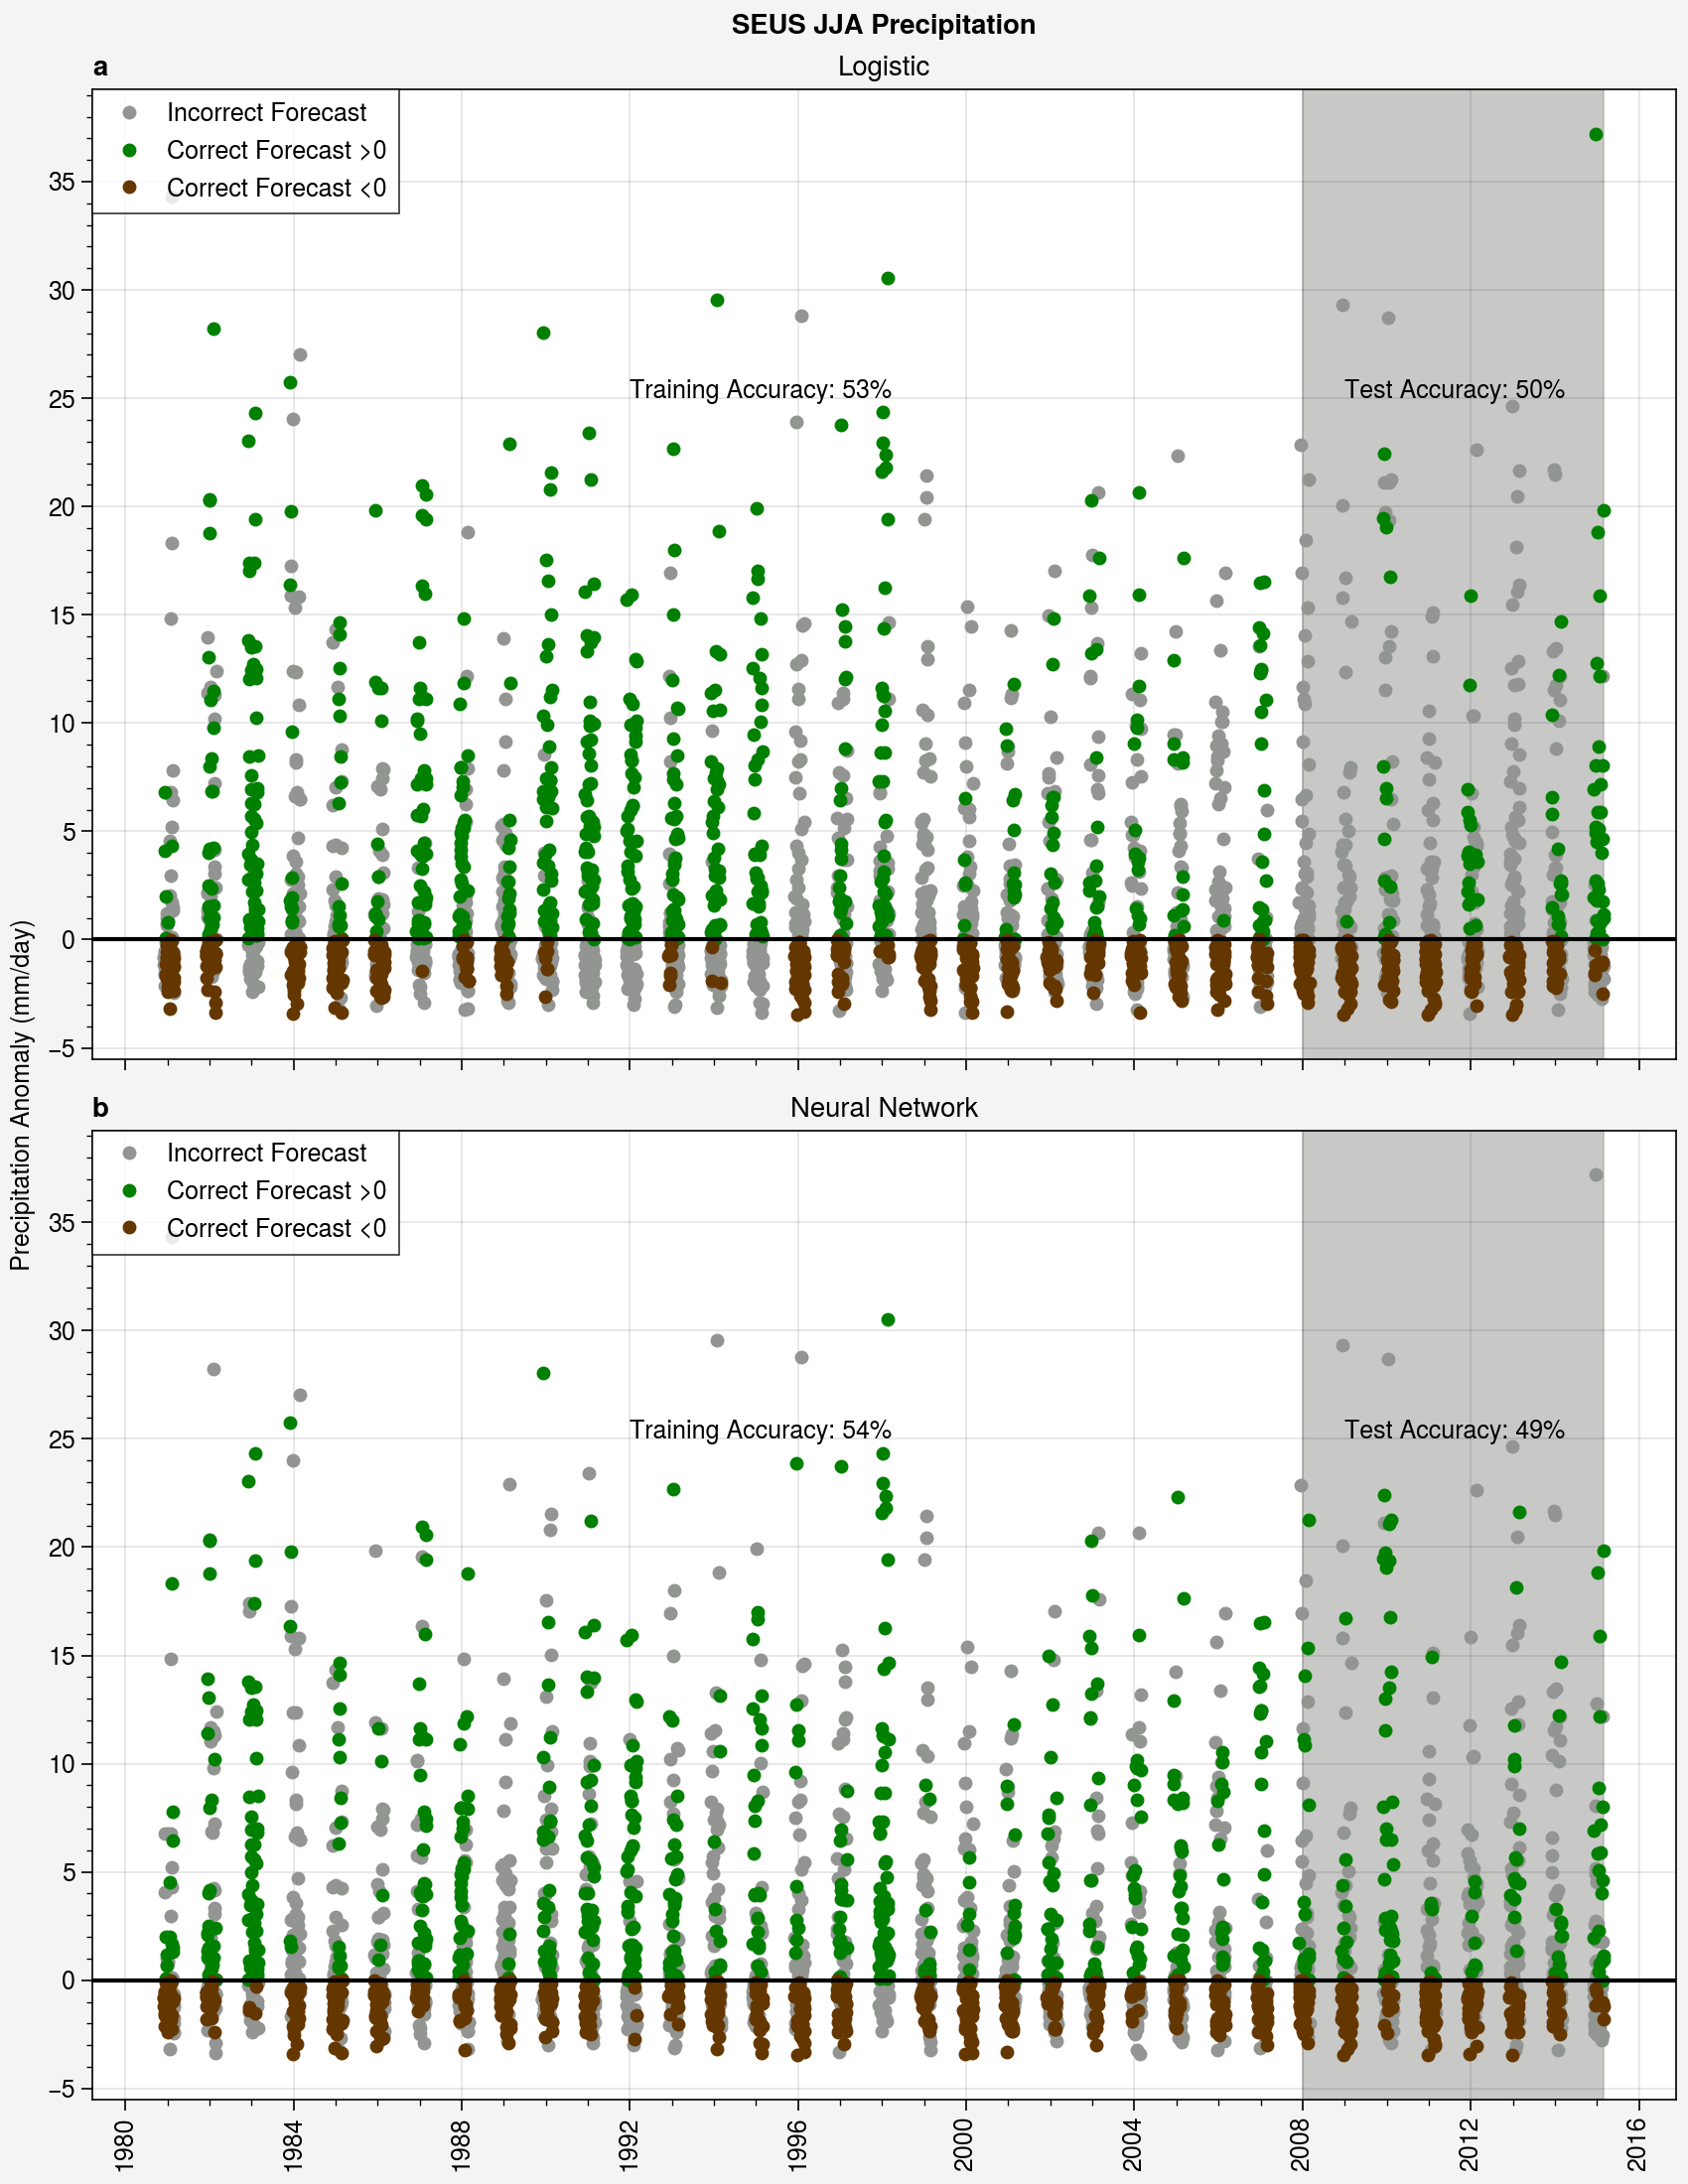

In [7]:
f,axs=pplt.subplots(ncols=1,nrows=len(ds_model['model_type'].values),figsize=(8.5,11))


for ax,mtype,l in zip(axs,ds_model['model_type'].values,['Logistic','Neural Network']):
 
    hs=[]
    
    # Select the model type
    ds=ds_model.sel(model_type=mtype)
    da=ds[varname]
    da_pred=ds['pred'].sel(model=0)
    da_verif=ds['verif'].sel(model=0)
    thresh=np.percentile(da,50)

    # Plot gray where fcsts are not correct
    tmp=da.where(da_pred!=da_verif)
    h=ax.plot(tmp['time'],tmp,color='gray',marker='.',markersize=8,linestyle='None')
    hs.append(h)
    
    # Plot correct positive forecasts in green
    tmp=da.where(np.logical_and(da_pred==da_verif,da>=thresh))
    h=ax.plot(tmp['time'],tmp,'g.',markersize=8,linestyle='None')
    hs.append(h)
    
    # Plot correct negative forecasts in brown
    tmp=da.where(np.logical_and(da_pred==da_verif,da<thresh))
    h=ax.plot(tmp['time'],tmp,color='brown',marker='.',markersize=8,linestyle='None')
    hs.append(h)

    # Draw median line
    ax.axhline(thresh,color='k')
    
    # Highlight test data
    ax.axvspan(ds_model['time'][2403].values, ds_model['time'][-1].values, color='gray', alpha=0.5)
    
    # Format subplot panel
    ax.format(title=l,abc=True)
    
    # Add custom legend
    ax.legend(hs, labels=['Incorrect Forecast', 'Correct Forecast >0','Correct Forecast <0'],ncols=1, loc='ul') 
    
    # Add text indicating accuracy of this model for test and train
    train_str='Training Accuracy: '+str(int(ds['acc'].sel(model=0)*100))+'%'
    test_str='Test Accuracy: '+str(int(ds['val_acc'].sel(model=0)*100))+'%'
    ax.text(pd.to_datetime('1992-01-01'),25,train_str,transform='data')
    ax.text(pd.to_datetime('2009-01-01'),25,test_str,transform='data')

# Figure labels
f.format(xlabel='', ylabel='Precipitation Anomaly (mm/day)',suptitle='SEUS JJA Precipitation')
    

### Figure 1: June-Jul-Aug SEUS observed and forecasted precipitation anomaly (mm/day) over the training and testing (gray shading) period (1979-2015). Forecasts are categorical for positive or negative anomalies from a logistic regression model (a) and a neural network (b).  Incorrect forecasts are indicated in gray.  Correct forecasts for positive anomalies are green.  Correct forecasts for negative anomalies are brown.

### Confusion Matrix/Contingency Table

TP:  768  FP:  681  TN:  858  FN:  772
TP:  746  FP:  642  TN:  897  FN:  794


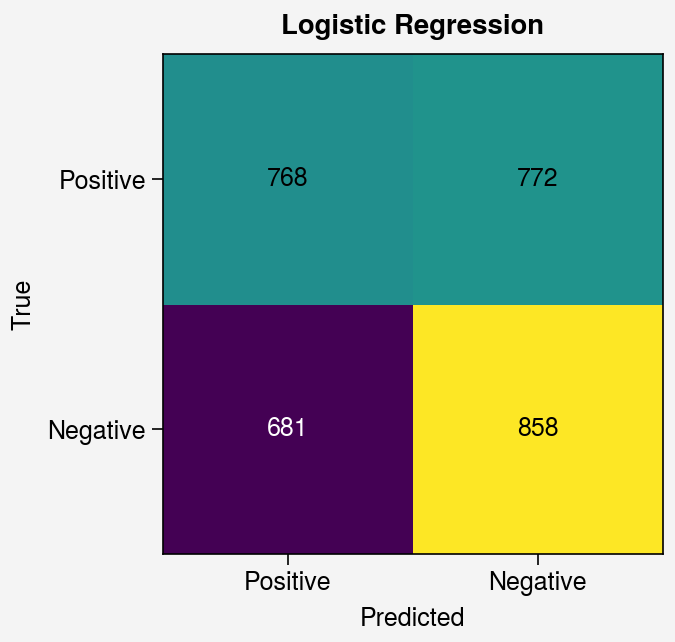

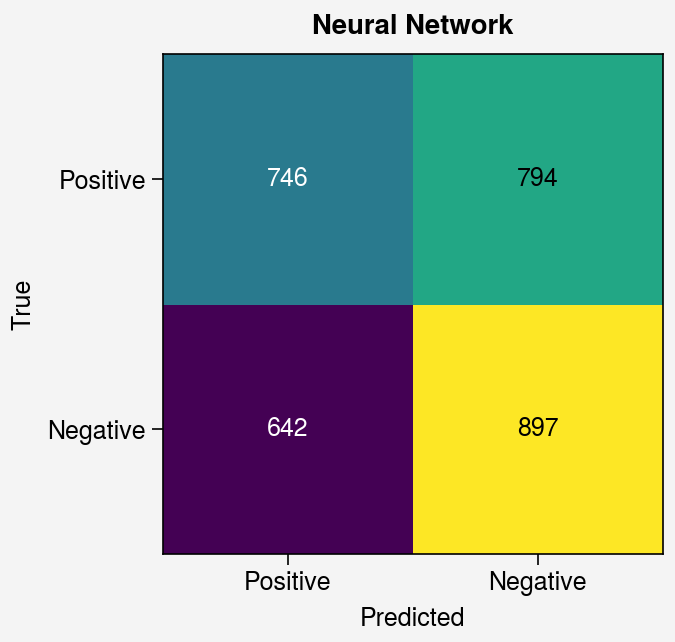

In [8]:
for i,t in zip(ds_model['model_type'].values,['Logistic Regression','Neural Network']):
    make_cm(ds_model,i,title=t)

Both models are better at predicting negative anomlay precipitation than positive anomaly precipitation.  

# Acccuracy

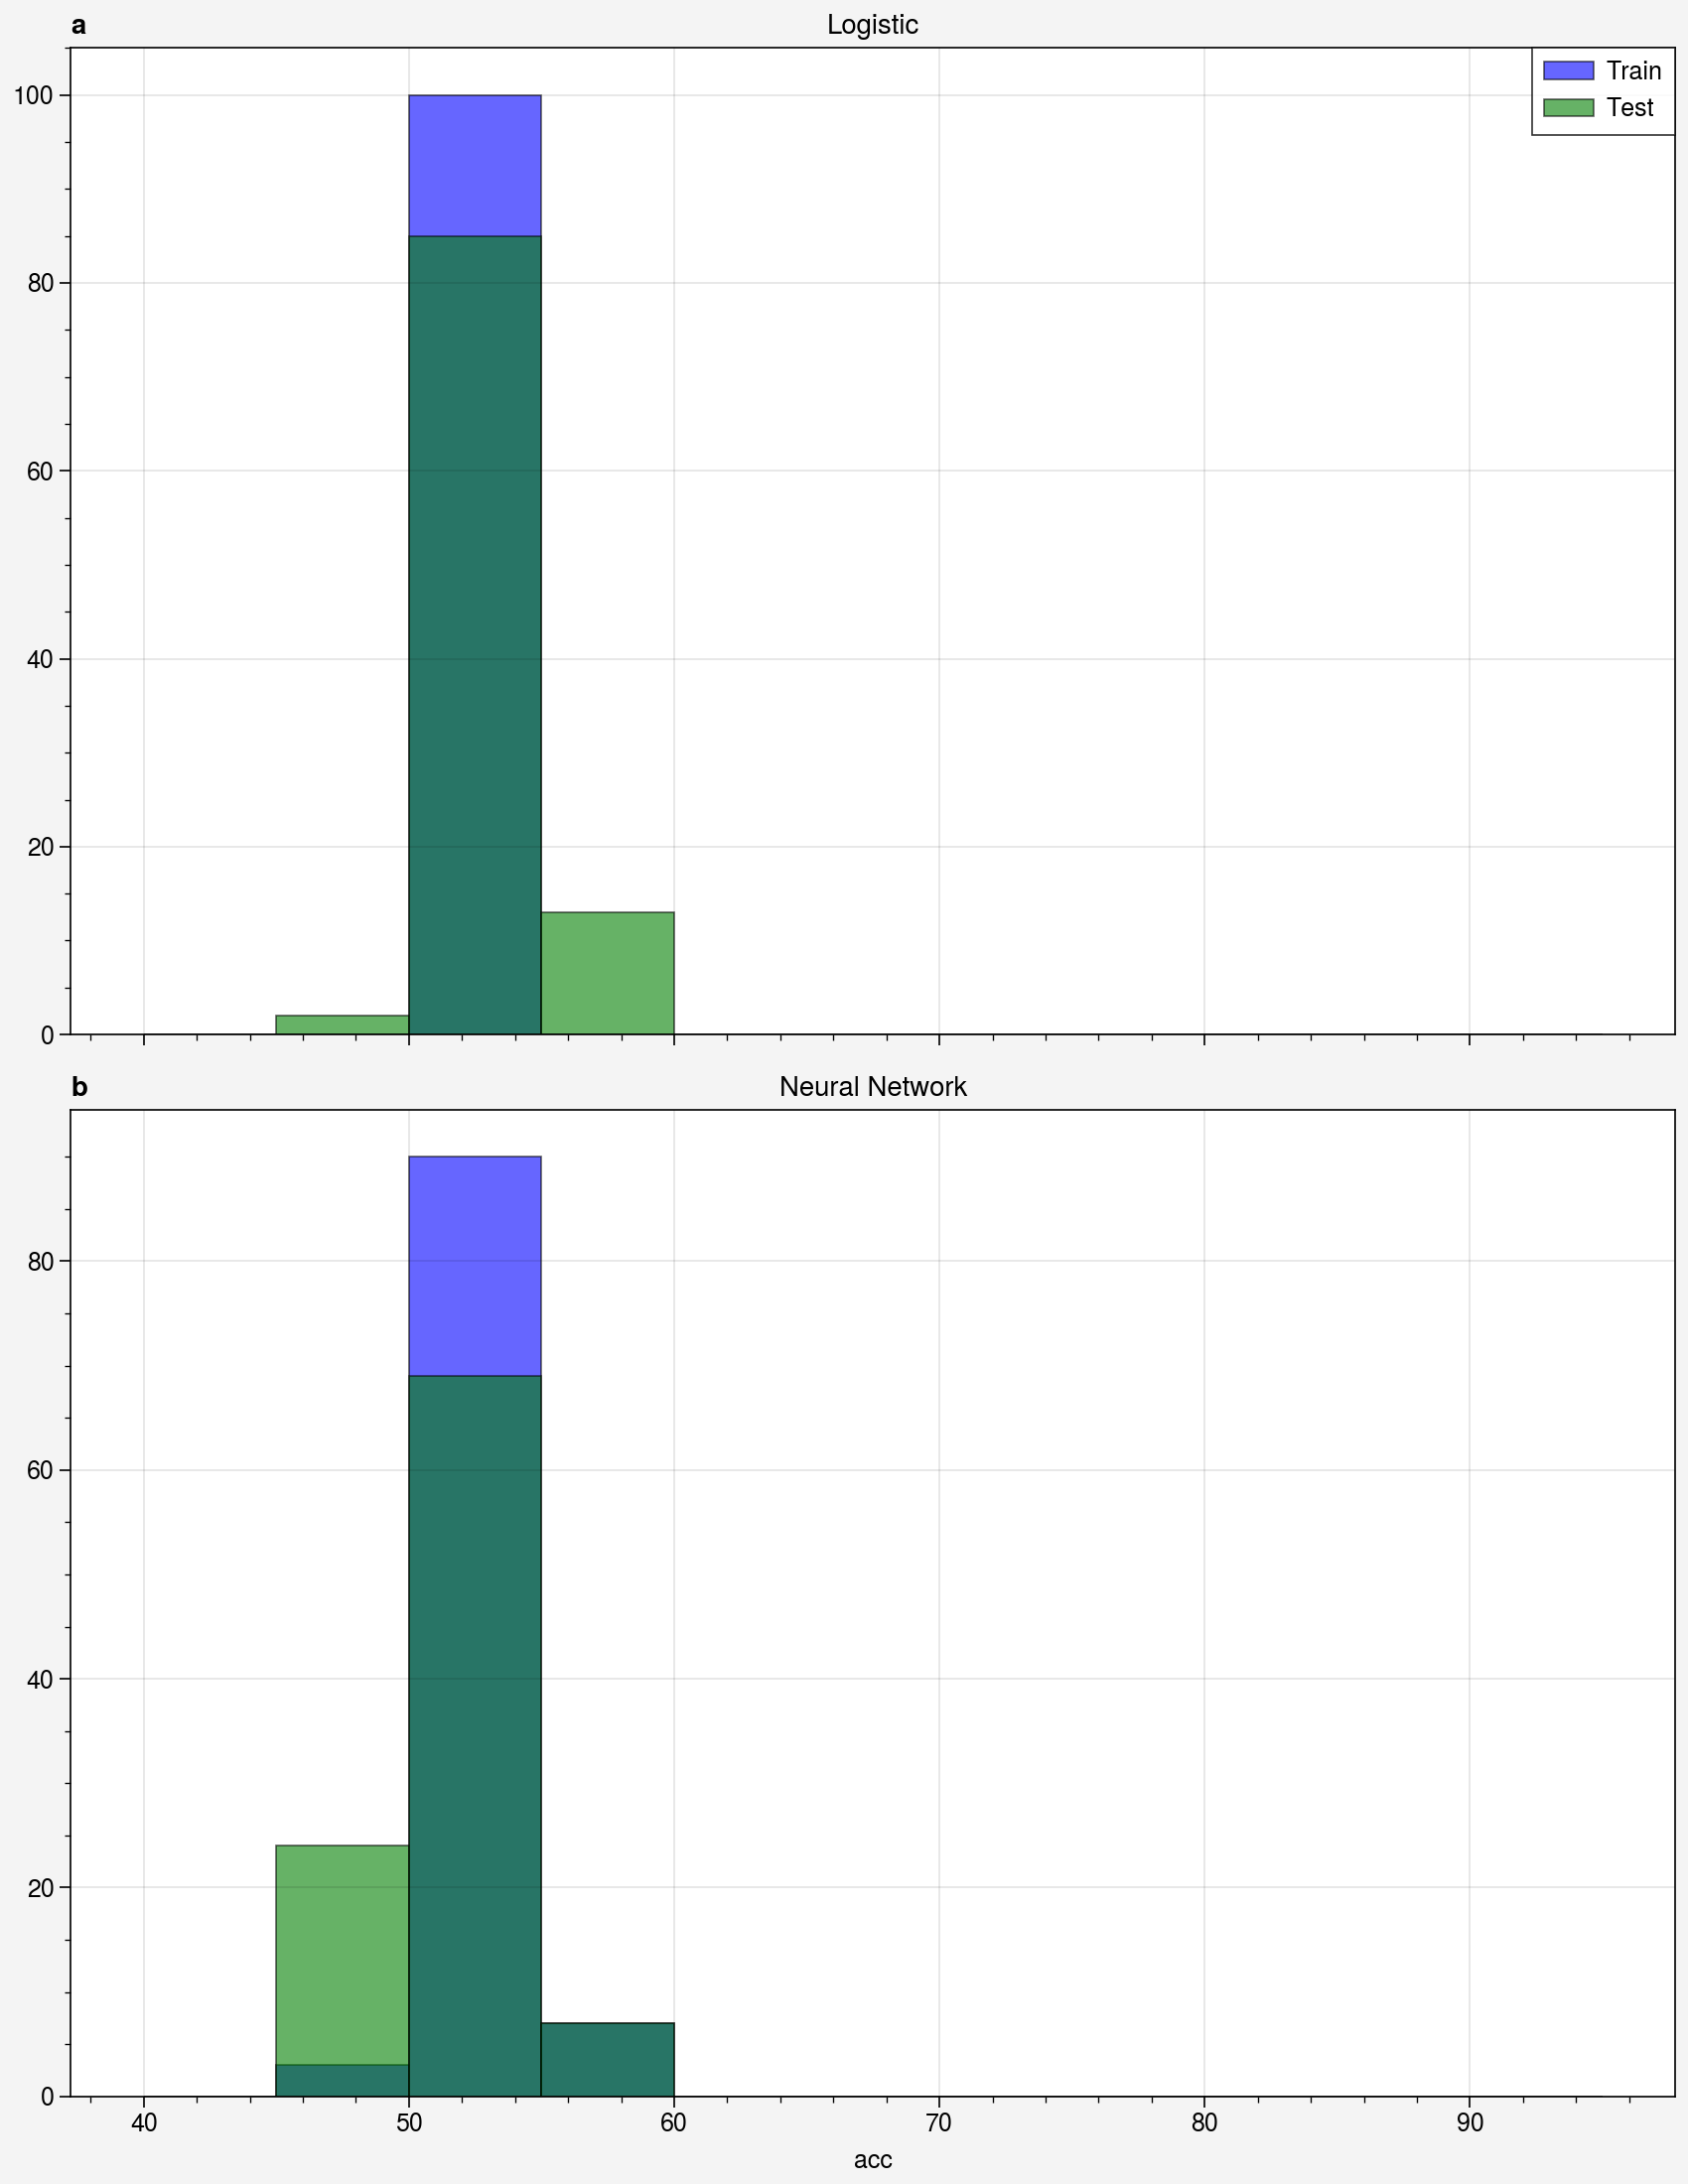

In [9]:
hist_bins=np.arange(40,100,5)
f,axs=pplt.subplots(ncols=1,nrows=len(ds_model['model_type'].values),figsize=(8.5,11))

for ax,mtype,l in zip(axs,ds_model['model_type'].values,['Logistic','Neural Network']):

    hs=[]
    
    # Select the model type
    ds=ds_model.sel(model_type=mtype)
       
    h=ax.hist(ds['acc']*100,hist_bins,edgecolor='k',color='b',alpha=0.6)
    hs.append(h)
    
    h=ax.hist(ds['val_acc']*100,hist_bins,edgecolor='k',color='g',alpha=0.6)
    hs.append(h)
    
    # Format subplot panel
    ax.format(title=l,abc=True)

# Add custom legend
axs[0,0].legend(hs, labels=['Train','Test'],ncols=1, loc='ur') 


### Figure 2: Histogram of training (blue) and testing (green) accuracy for 100 logistic regression models (a) and neural networks (b)

# Reliability

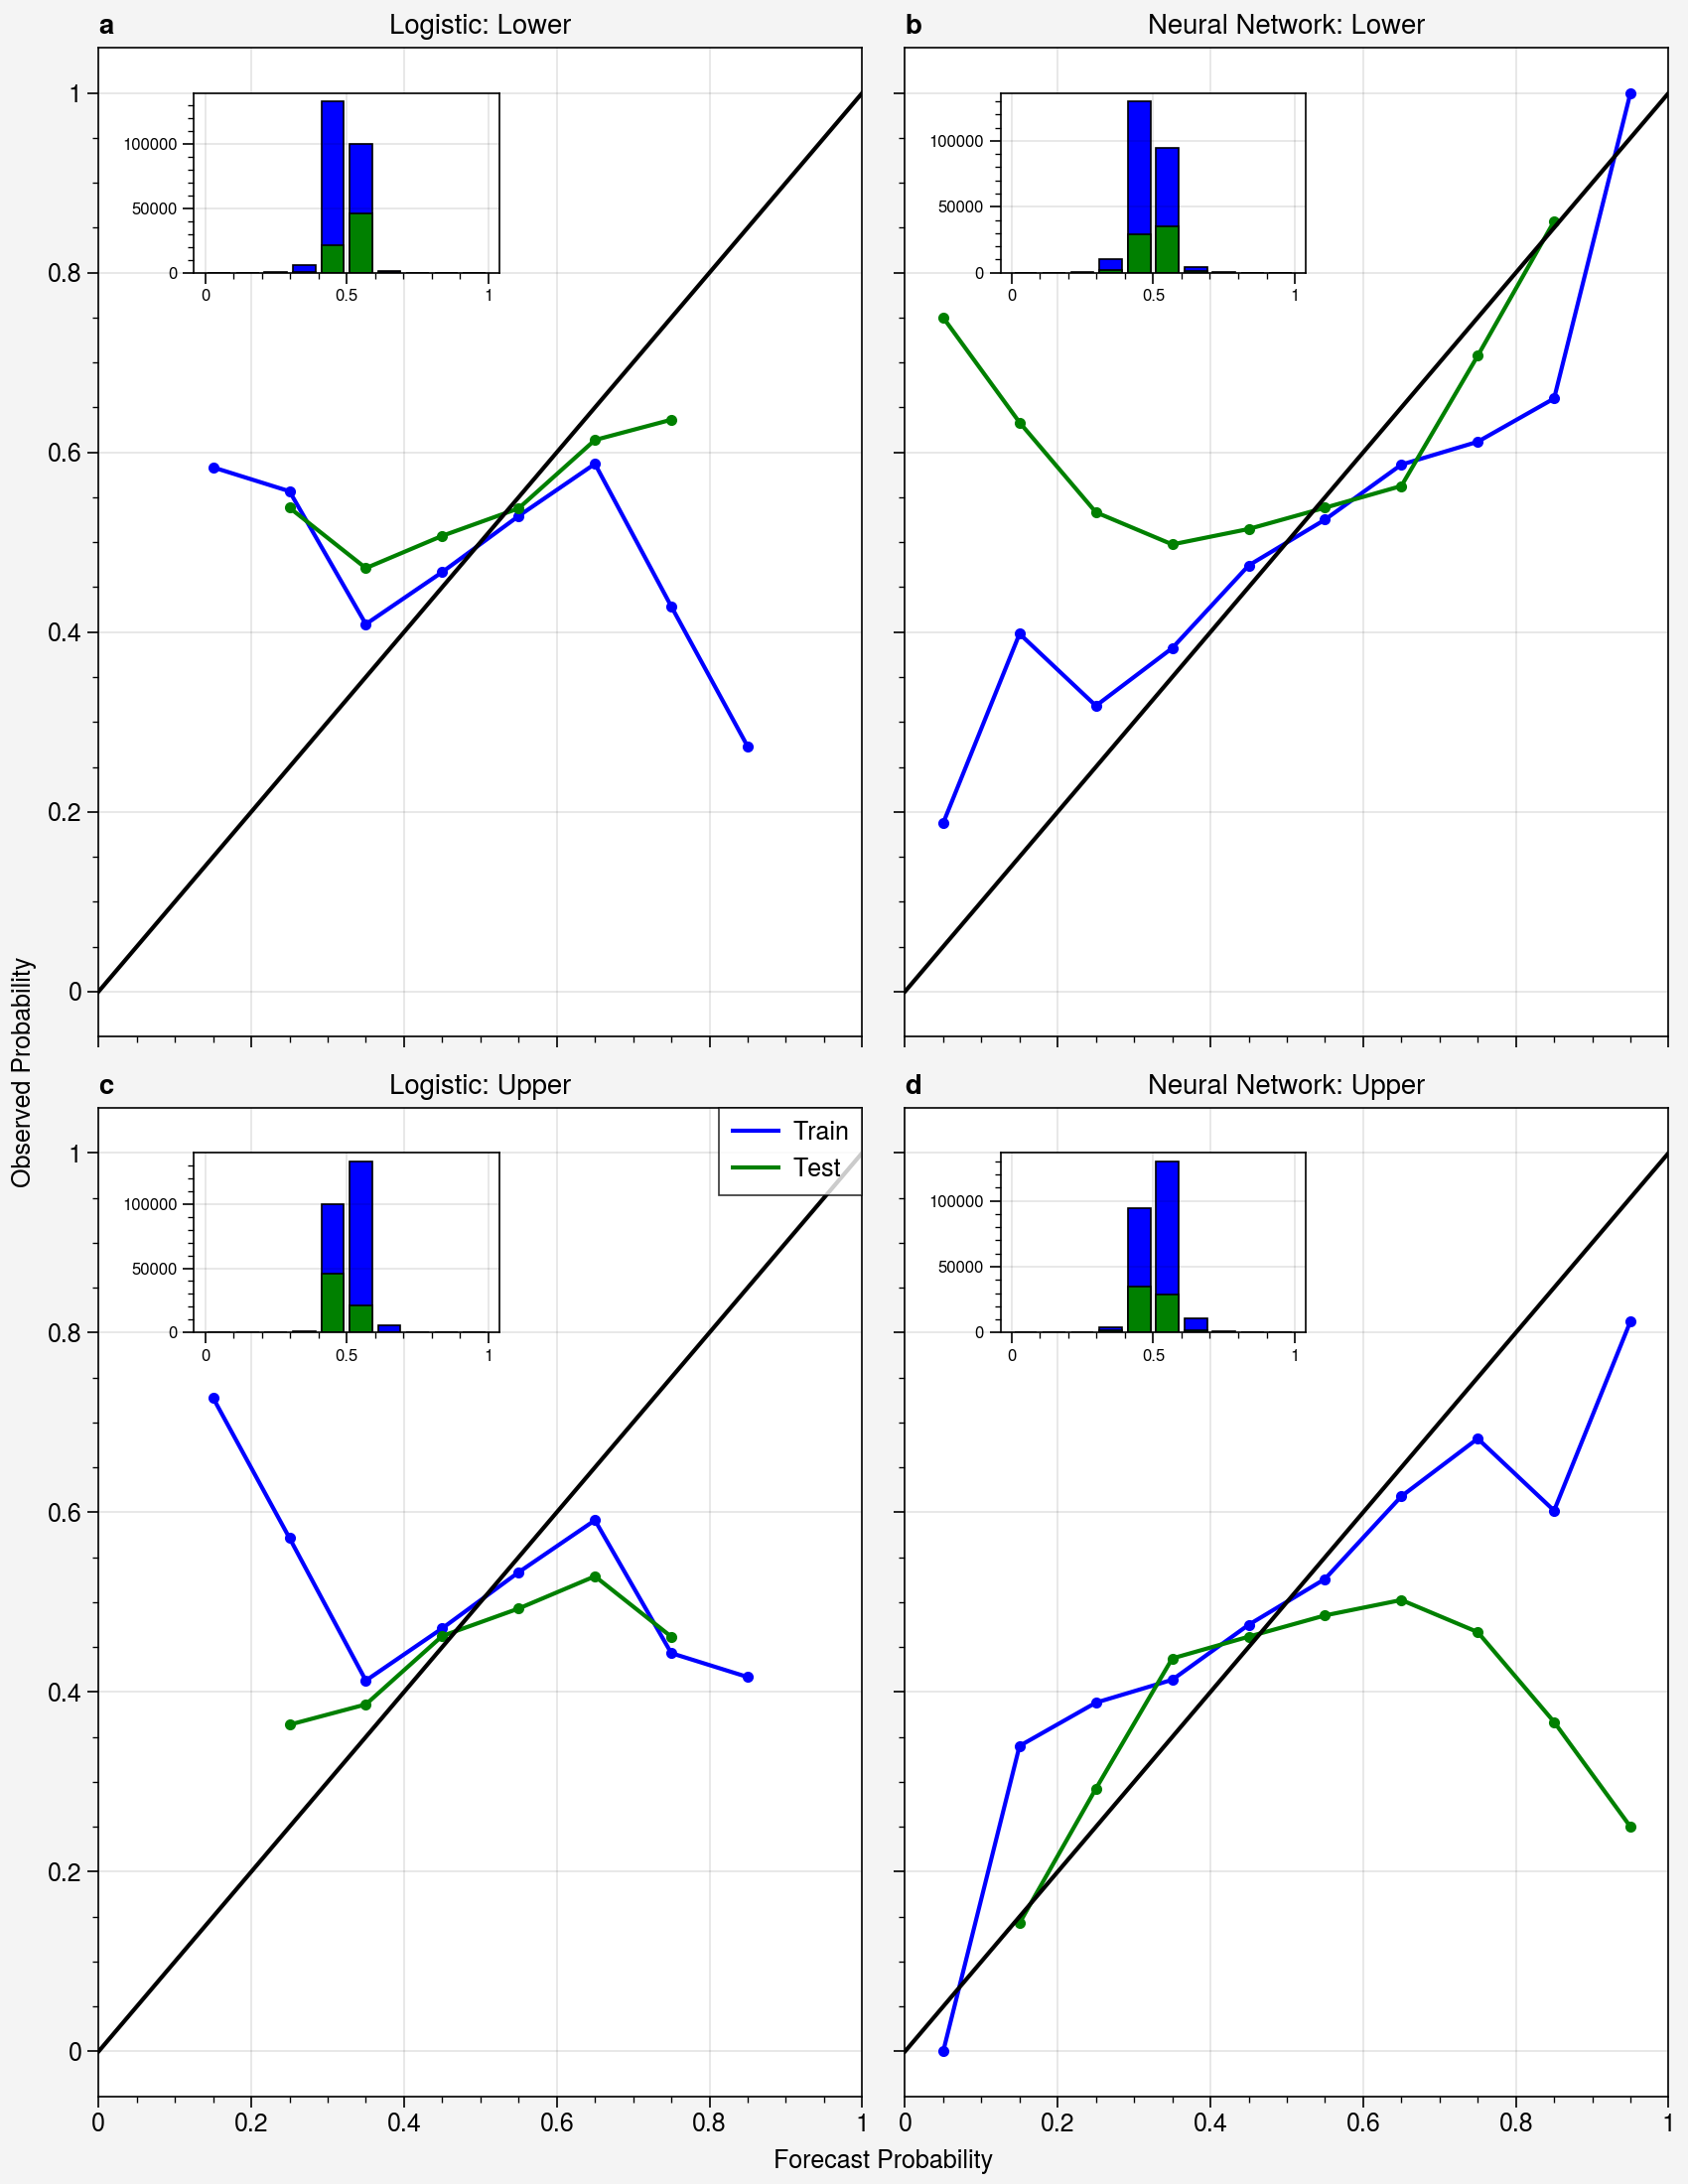

In [10]:
f, axs = pplt.subplots(ncols=len(ds_model['model_type'].values),nrows=len(ds_model['cat'].values),figsize=(8.5,11))

rel_bins=np.arange(0,1.1,0.1)
   

for j,(mtype,l) in enumerate(zip(ds_model['model_type'].values,['Logistic','Neural Network'])): 
    
    # Select the model
    ds=ds_model.sel(model_type=mtype)
    ds_train=xr.where(ds['tt']==0,ds,np.nan)
    ds_test=xr.where(ds['tt']==1,ds,np.nan)
    
    
    for i,cat in enumerate(ds['cat'].values):
        
        hs=[]
        
        # Calculate reliability
        rel_train=xs.reliability(ds_train['verif']==i,ds_train['probs'].sel(cat=cat),dim=['model','time'],
                                 probability_bin_edges=rel_bins)
        rel_test=xs.reliability(ds_test['verif']==i,ds_test['probs'].sel(cat=cat),dim=['model','time'],
                                 probability_bin_edges=rel_bins)
        
        # Plot reliability
        h=axs[i,j].plot(rel_train['forecast_probability'],rel_train,'b')
        axs[i,j].plot(rel_train['forecast_probability'],rel_train,'b.')
        hs.append(h)
        
        h=axs[i,j].plot(rel_test['forecast_probability'],rel_test,'g')
        axs[i,j].plot(rel_test['forecast_probability'],rel_test,'g.')
        hs.append(h)
        
        axs[i,j].format(xtickminor=True,ytickminor=True,title=l+': '+cat,
                        xlabel='Forecast Probability',ylabel='Observed Probability',
                        abc=True)
        
        # Perfect reliability line
        axs[i,j].plot(rel_bins,rel_bins,'k')
        
        # Histogram inset
        axi = axs[i,j].inset([0.125, 0.8, 0.4, 0.2], transform='data',zoom=False)
        axi.bar(rel_train['samples'],color='b')
        axi.bar(rel_test['samples'],color='g')

        axi.format(xtickminor=True,ytickminor=True,fontsize=6)
        
    # Add custom legend
    axs[1,0].legend(hs, labels=['Train','Test'],ncols=1, loc='ur')


### Figure 3: Reliability of negative (a,c) and positive (b,d) anomaly forecasts from 100 logistic regression models (a,b) and neural networks (c,d)

# Contribution of Predictors

### Look at LRP for some of the models

/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/proplot/axes/plot.py:1930: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = getattr(super(), name)(*args, **kwargs)
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/proplot/axes/plot.py:1930: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = getattr(super(), name)(*args, **kwargs)
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/proplot/axes/plot.py:1930: Ma

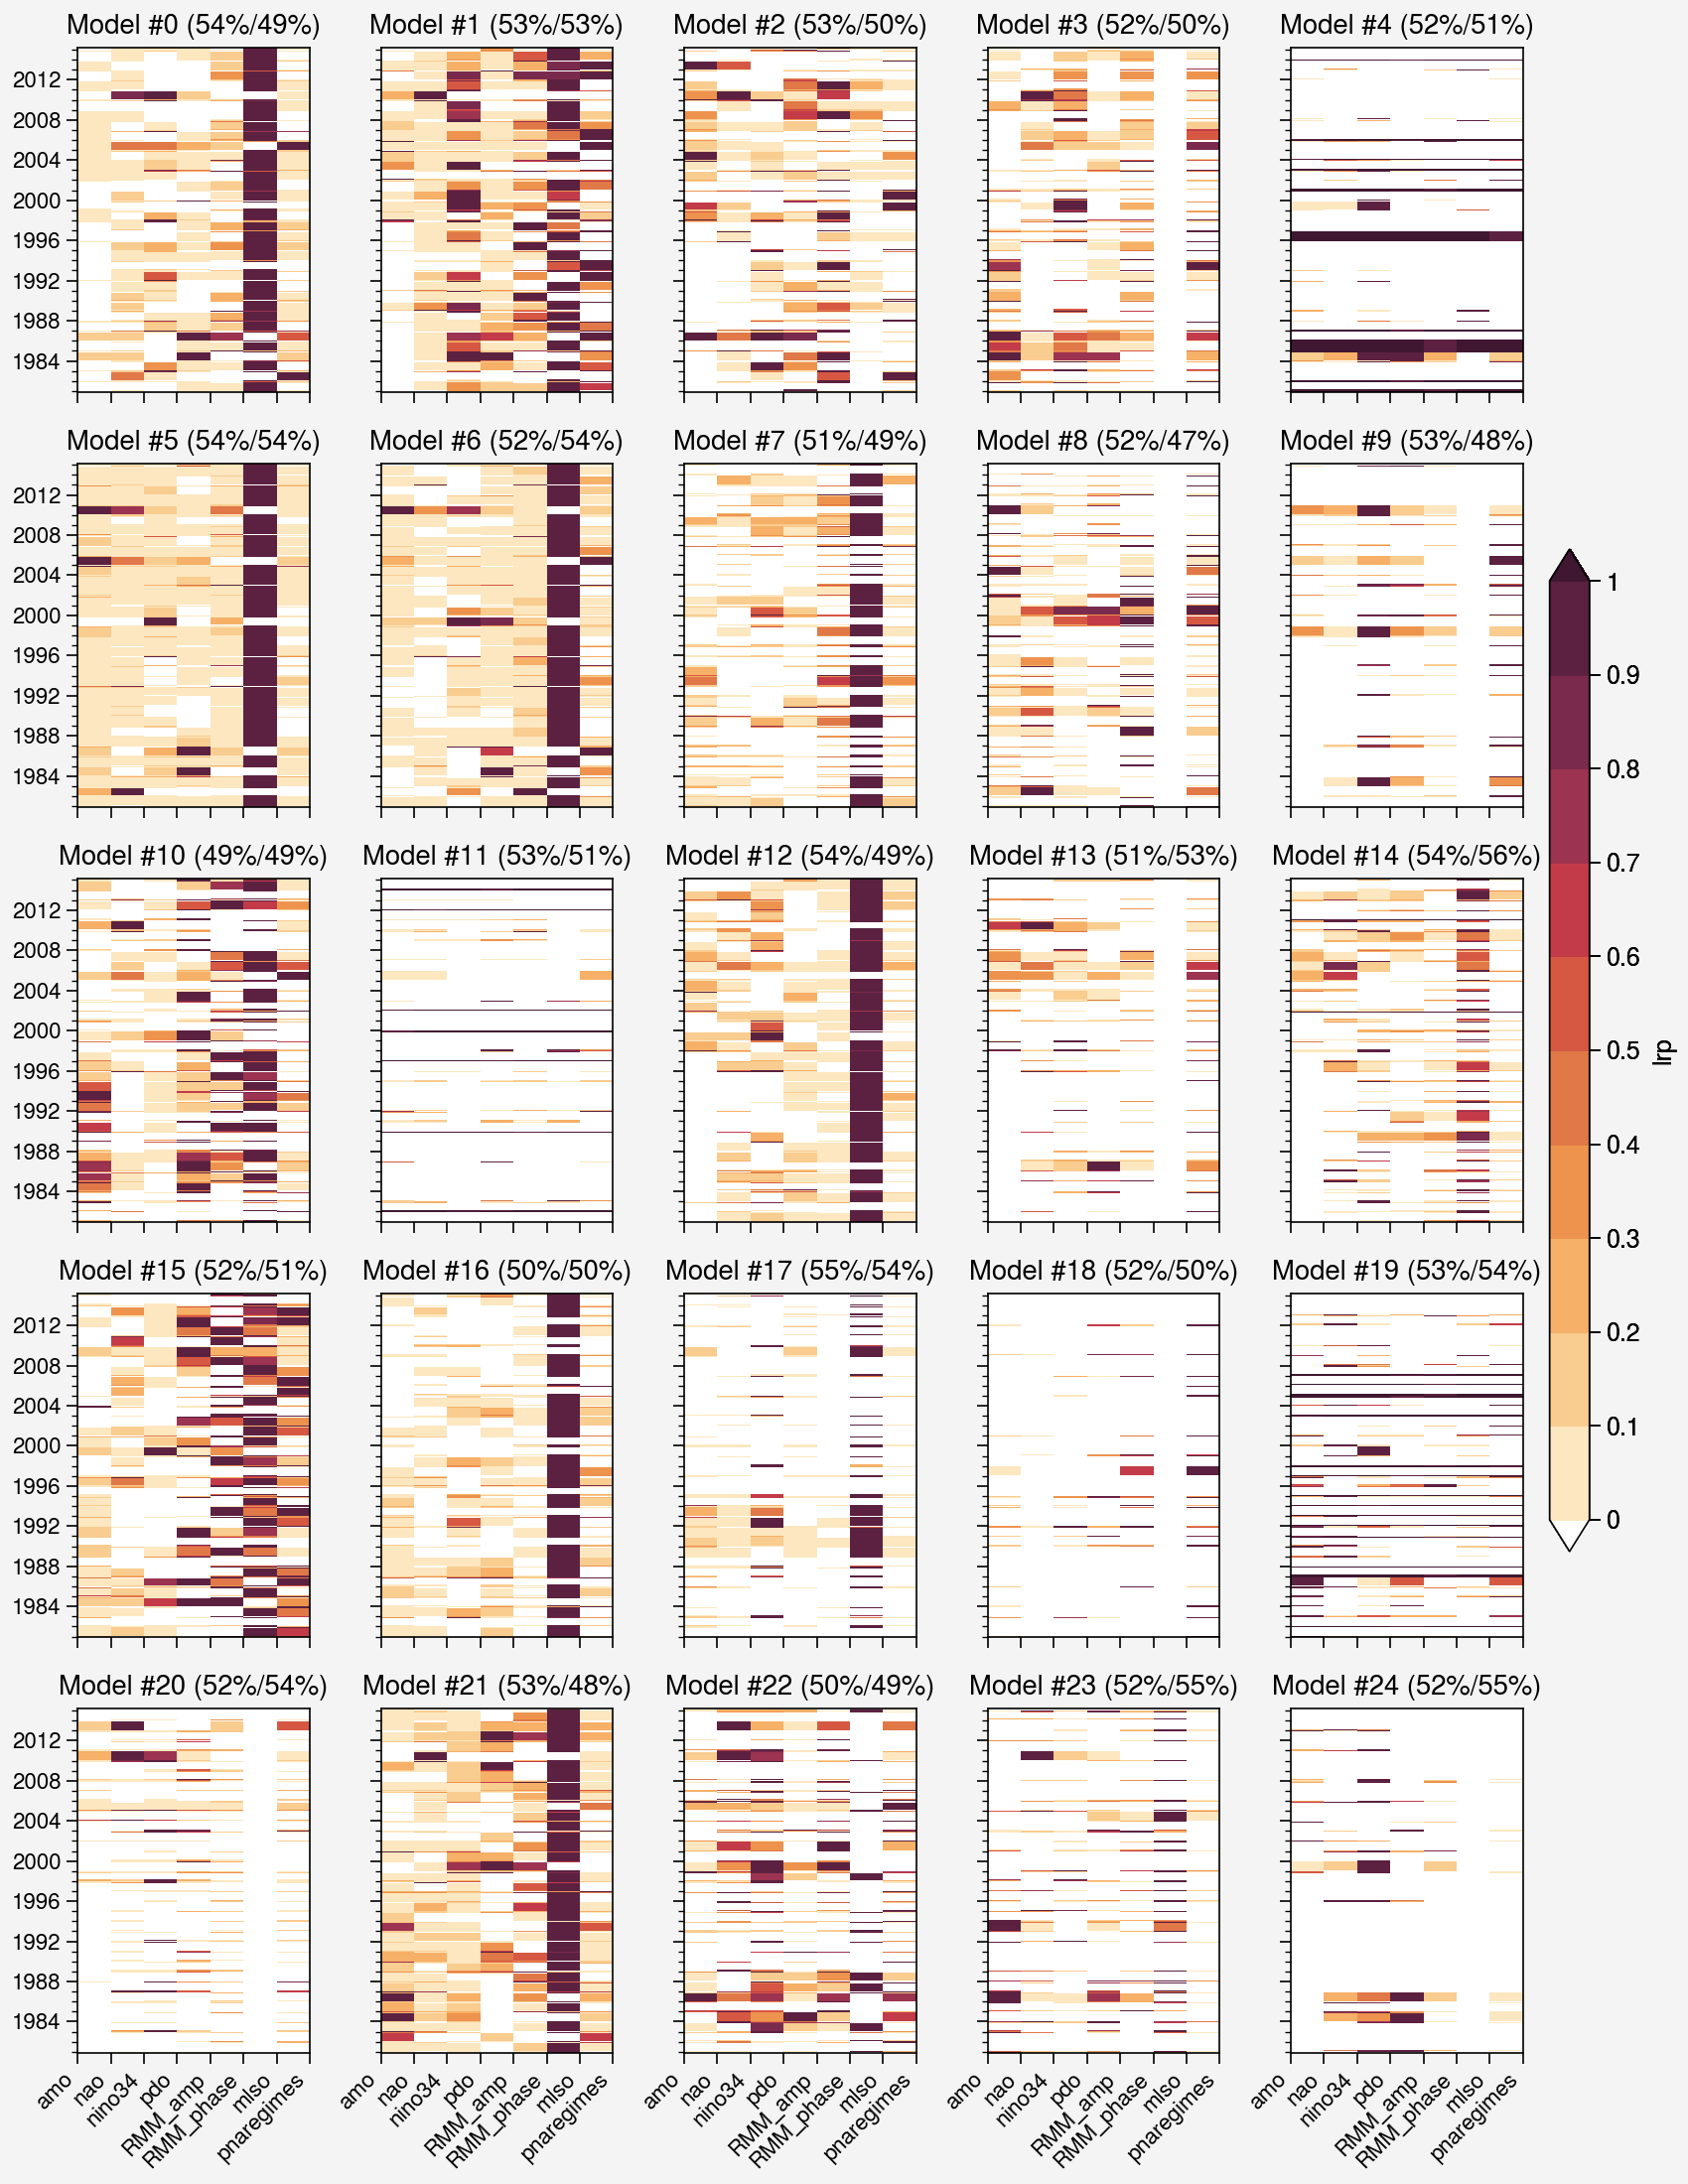

In [11]:
levs=np.arange(0,1.1,0.1)
#r='lrp.z'
r='lrp.alpha_1_beta_0'

f, axs = pplt.subplots(ncols=5,nrows=5,figsize=(8.5,11))
ds=ds_model.sel(model_type='nnmodel_med')

# Normalization
ds_max=ds['lrp'].max(dim='features',skipna=True)
ds['lrp']=xr.where(np.abs(ds_max)>1e-8,ds['lrp']/ds_max,np.nan)

for i,ax in enumerate(axs):
    
    m=ax.pcolormesh(ds['features'].values,ds['time'],ds['lrp'].sel(model=i,rules=r),levels=levs,extend='both',cmap='Fire')
    acc=str(int(ds['acc'].sel(model=i)*100))+'%/'+str(int(ds['val_acc'].sel(model=i)*100))+'%'
    ax.format(title='Model #'+str(int(i))+' ('+acc+')',xrotation=45,fontsize=8)
    
f.colorbar(m,loc='r',length=0.5)


# Mean Contribution of Predictors

['amo' 'nao' 'nino34' 'pdo' 'RMM_amp' 'RMM_phase' 'mlso' 'pnaregimes']
<xarray.DataArray 'lrp' (features: 8)>
array([0.0076722 , 0.04779026, 0.1548055 , 0.02273335, 0.10836142,
       1.083441  , 0.07126471, 0.3612957 ], dtype=float32)
Coordinates:
    rules       <U18 'lrp.alpha_1_beta_0'
  * features    (features) object 'amo' 'nao' 'nino34' ... 'mlso' 'pnaregimes'
    model       int64 0
    model_type  <U11 'nnmodel_med'


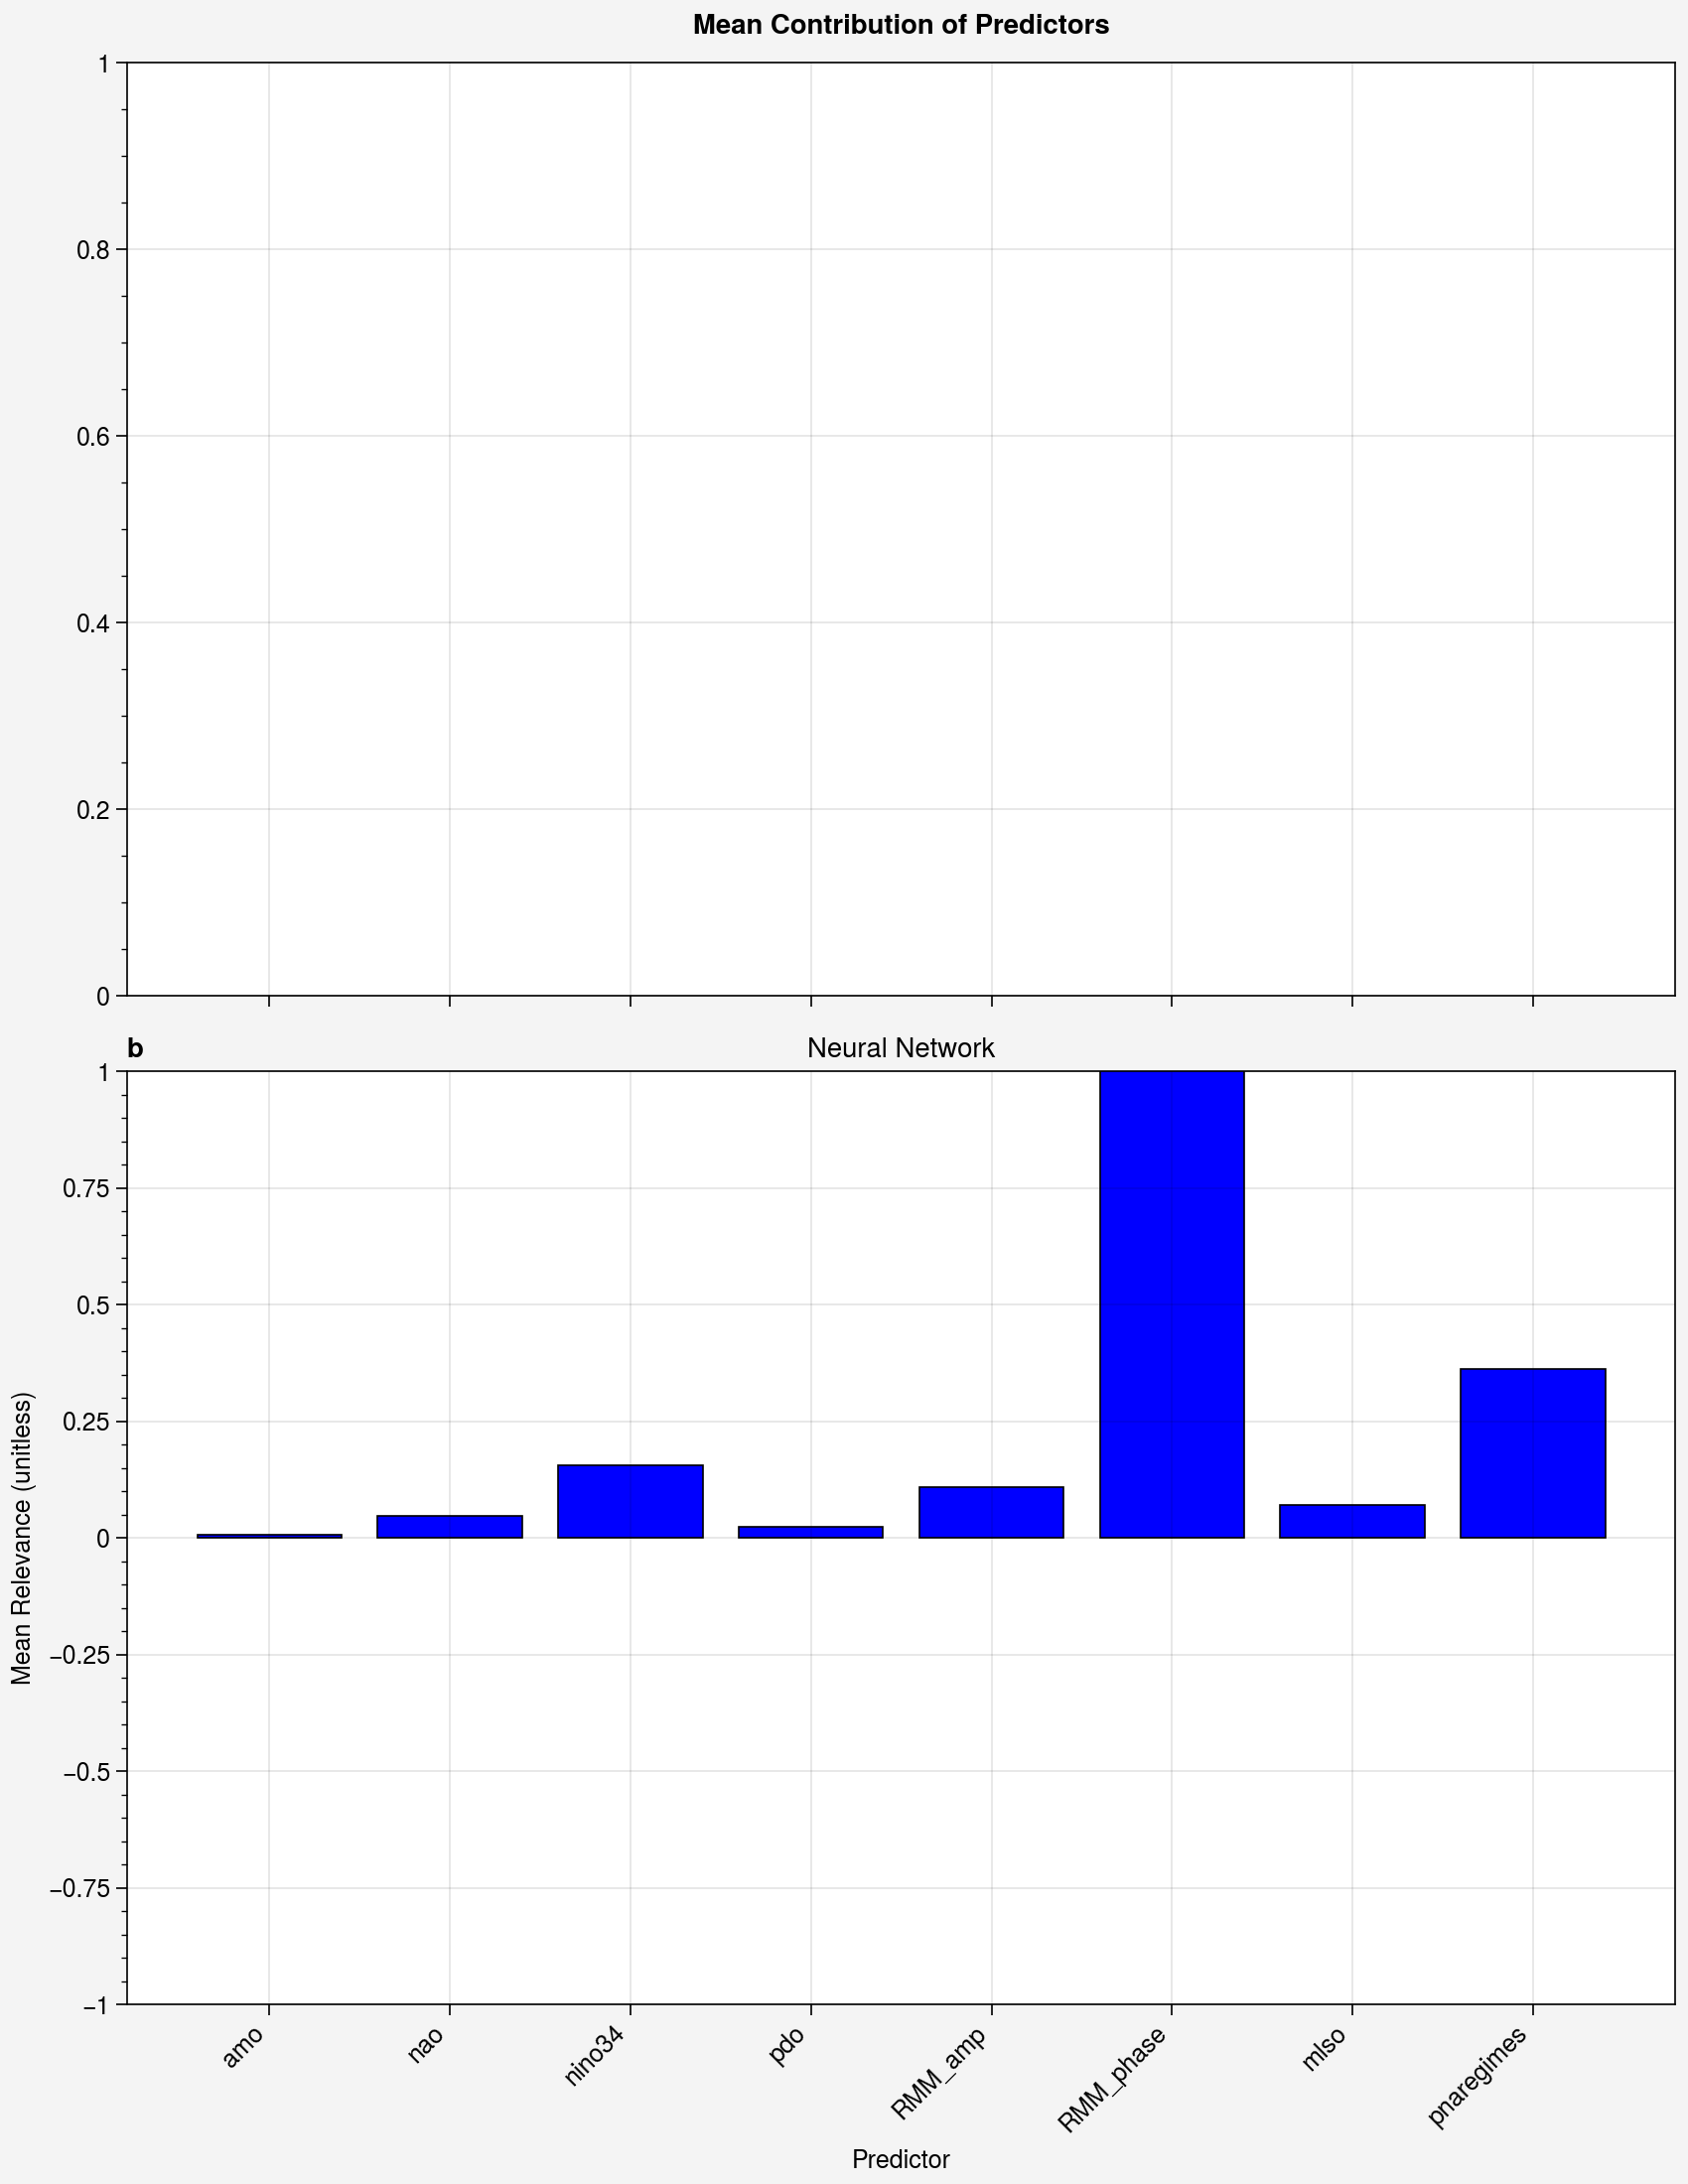

In [12]:
f,axs=pplt.subplots(ncols=1,nrows=2,figsize=(8.5,11))

# Logistic Regression Weights

# Neural Nework Relevance
ds=ds_model.sel(model_type='nnmodel_med')
x=ds['lrp'].sel(model=0)['features'].values
print(x)
y1=ds['lrp'].sel(model=0,rules=r).mean(dim=['time'],skipna=True)
print(y1)
axs[1].bar(x,y1,edgecolor='k',facecolor='b')  
axs[1].format(title='Neural Network',abc=True,xrotation=45,xlabel='Predictor', ylabel='Mean Relevance (unitless)',ylim=(-1,1))
f.format(suptitle='Mean Contribution of Predictors')


### Figure 4: Mean relevance (unitless) of predictors from 100 neural network over all models and all forecasts in the training and testing period. 

# Contribution of Predictors to Successful, Confident Forecasts

46


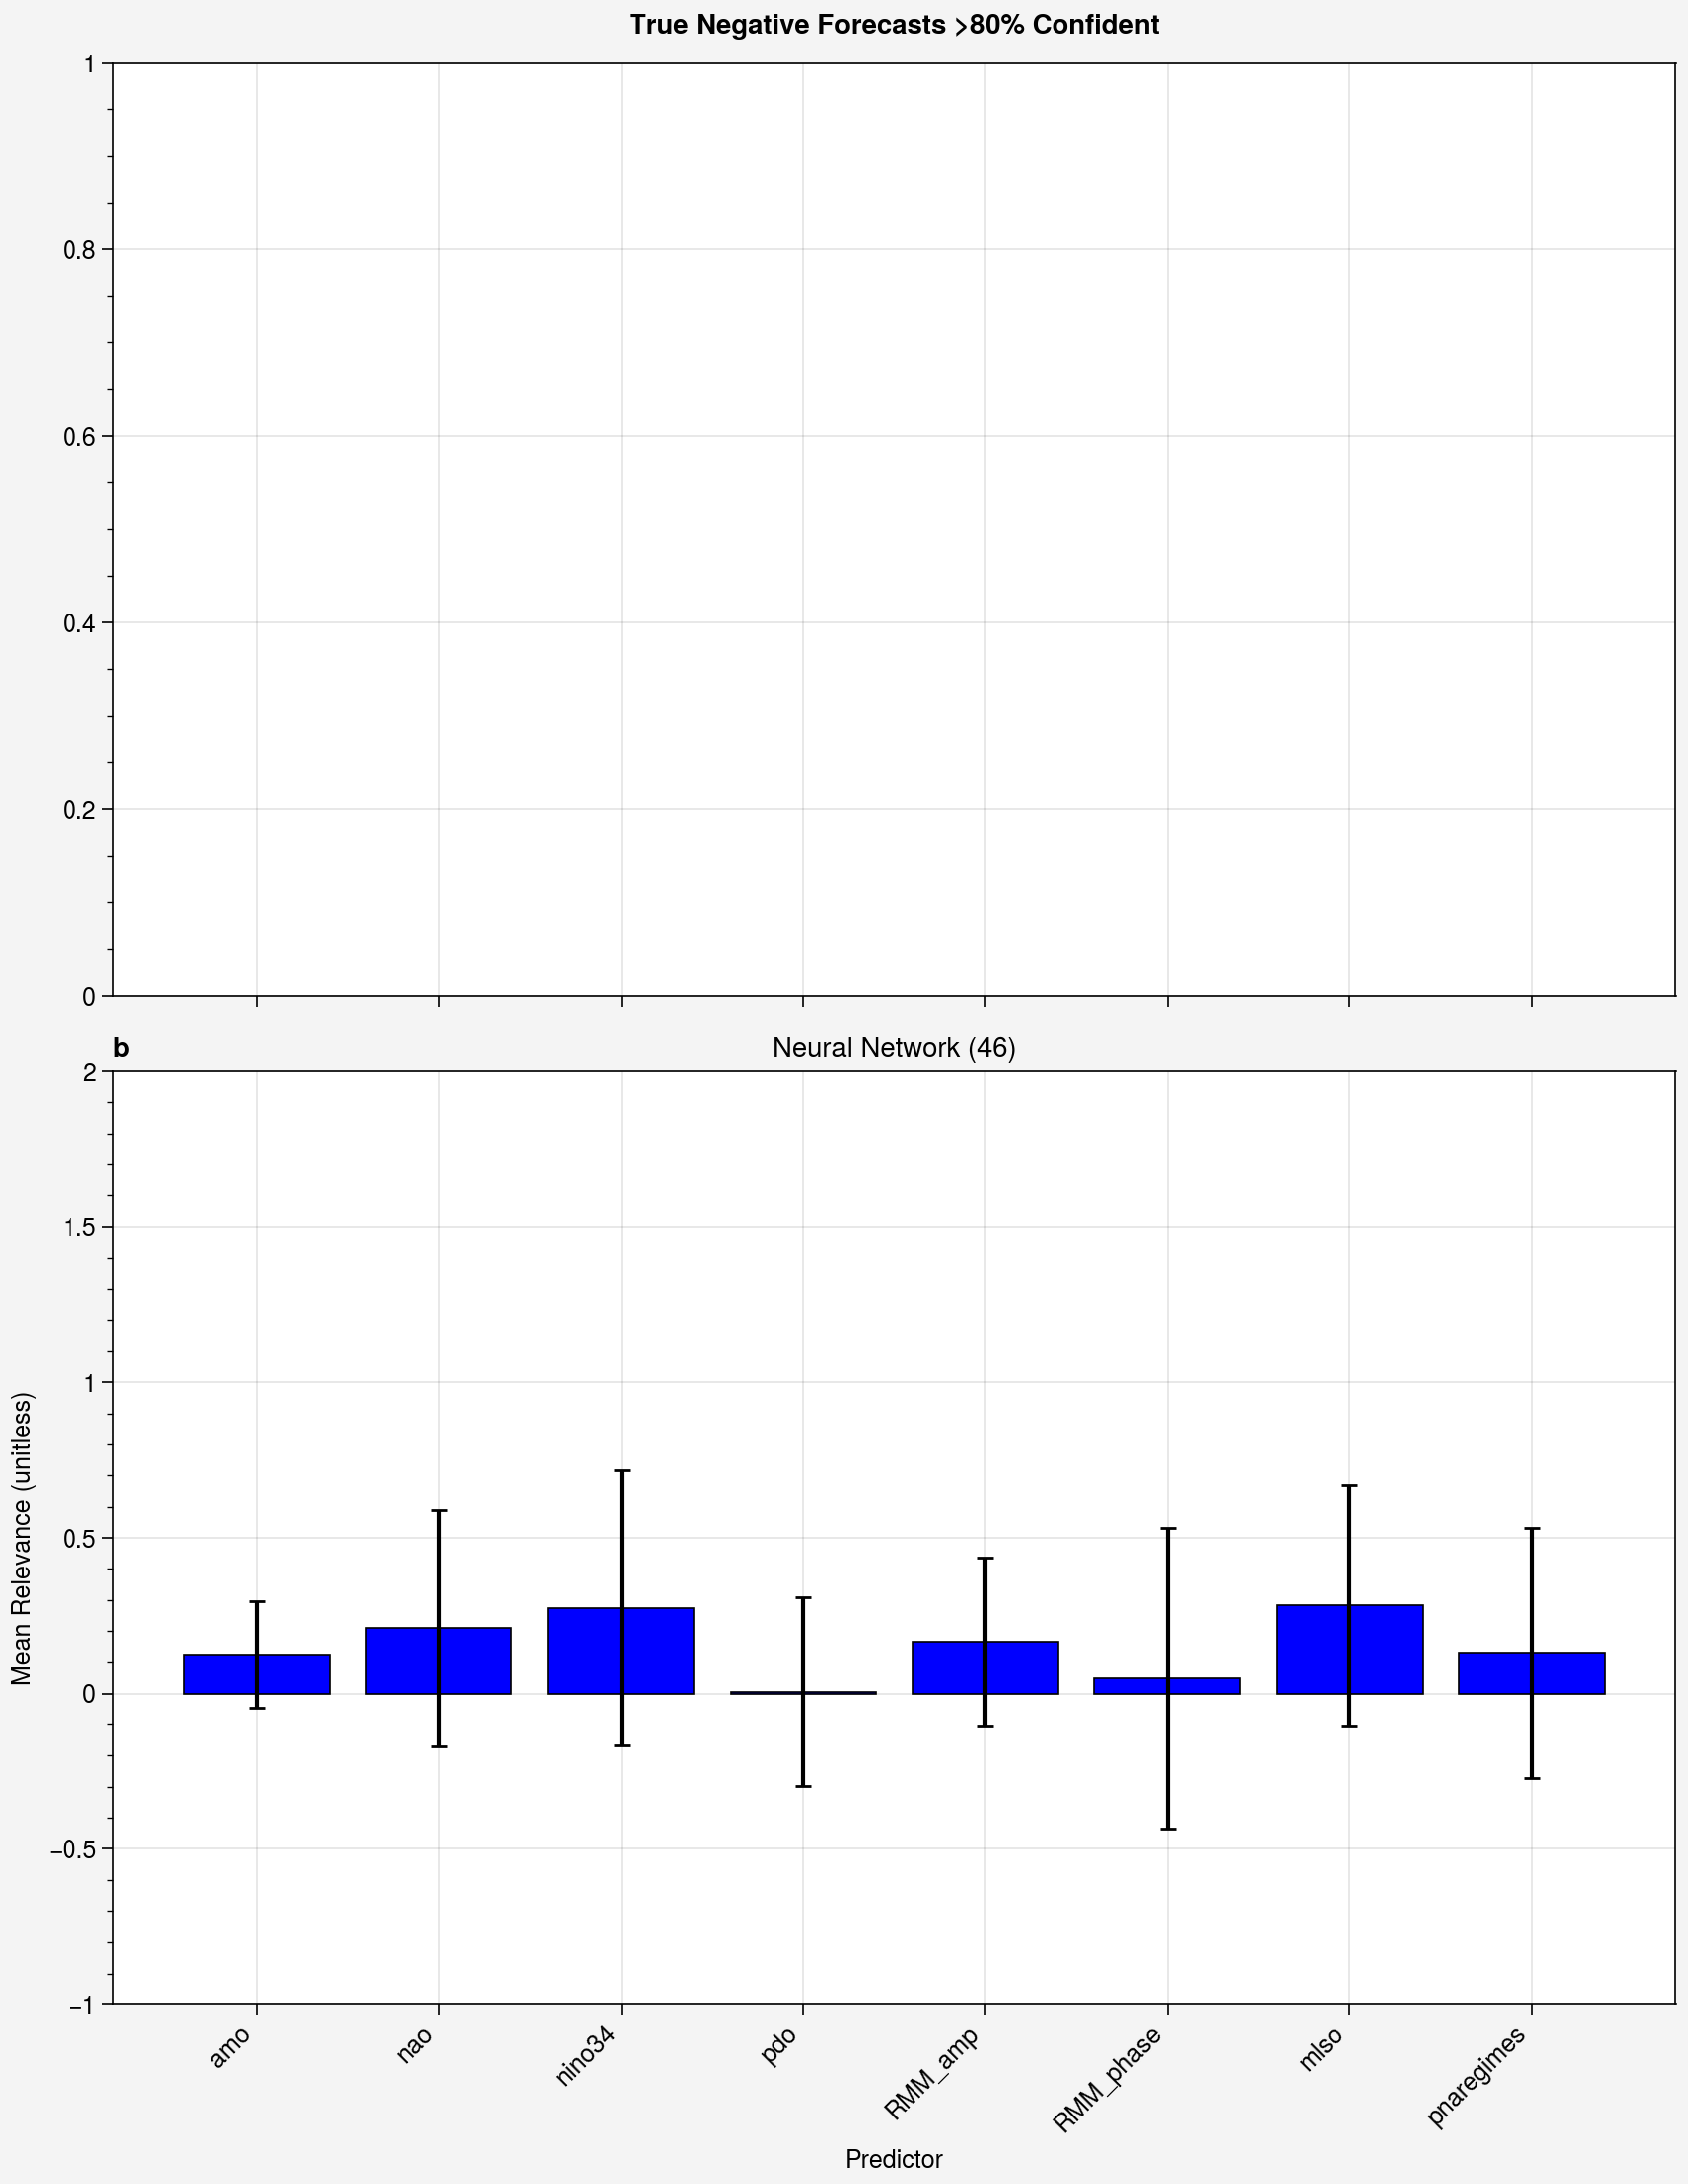

In [13]:
confidence_thresh=0.80
ds=ds_model.sel(model_type='nnmodel_med')
fcsts=ds.where(np.logical_and(ds['pred']==ds['verif'],ds['probs'].sel(cat='Lower')>=confidence_thresh))
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Lower')))))
print(count_str)

x=ds['lrp'].sel(model=0,rules=r)['features'].values
y1=fcsts['lrp'].sel(rules=r).mean(dim=['model','time'],skipna=True)
y2=fcsts['lrp'].sel(rules=r).std(dim=['model','time'],skipna=True)

f,axs=pplt.subplots(ncols=1,nrows=2,figsize=(8.5,11))

# Neural Nework Relevance
axs[1].bar(x,y1,yerr=y2,edgecolor='k',facecolor='b')  
axs[1].format(title='Neural Network ('+count_str+')',abc=True,xrotation=45,xlabel='Predictor', ylabel='Mean Relevance (unitless)',
             ylim=(-1,2))

f.format(suptitle='True Negative Forecasts >80% Confident')


### Figure 5: Mean relavance of predictors for successful forecasts with high confidence (>=80% probability) of negative precipitation anomaly

91


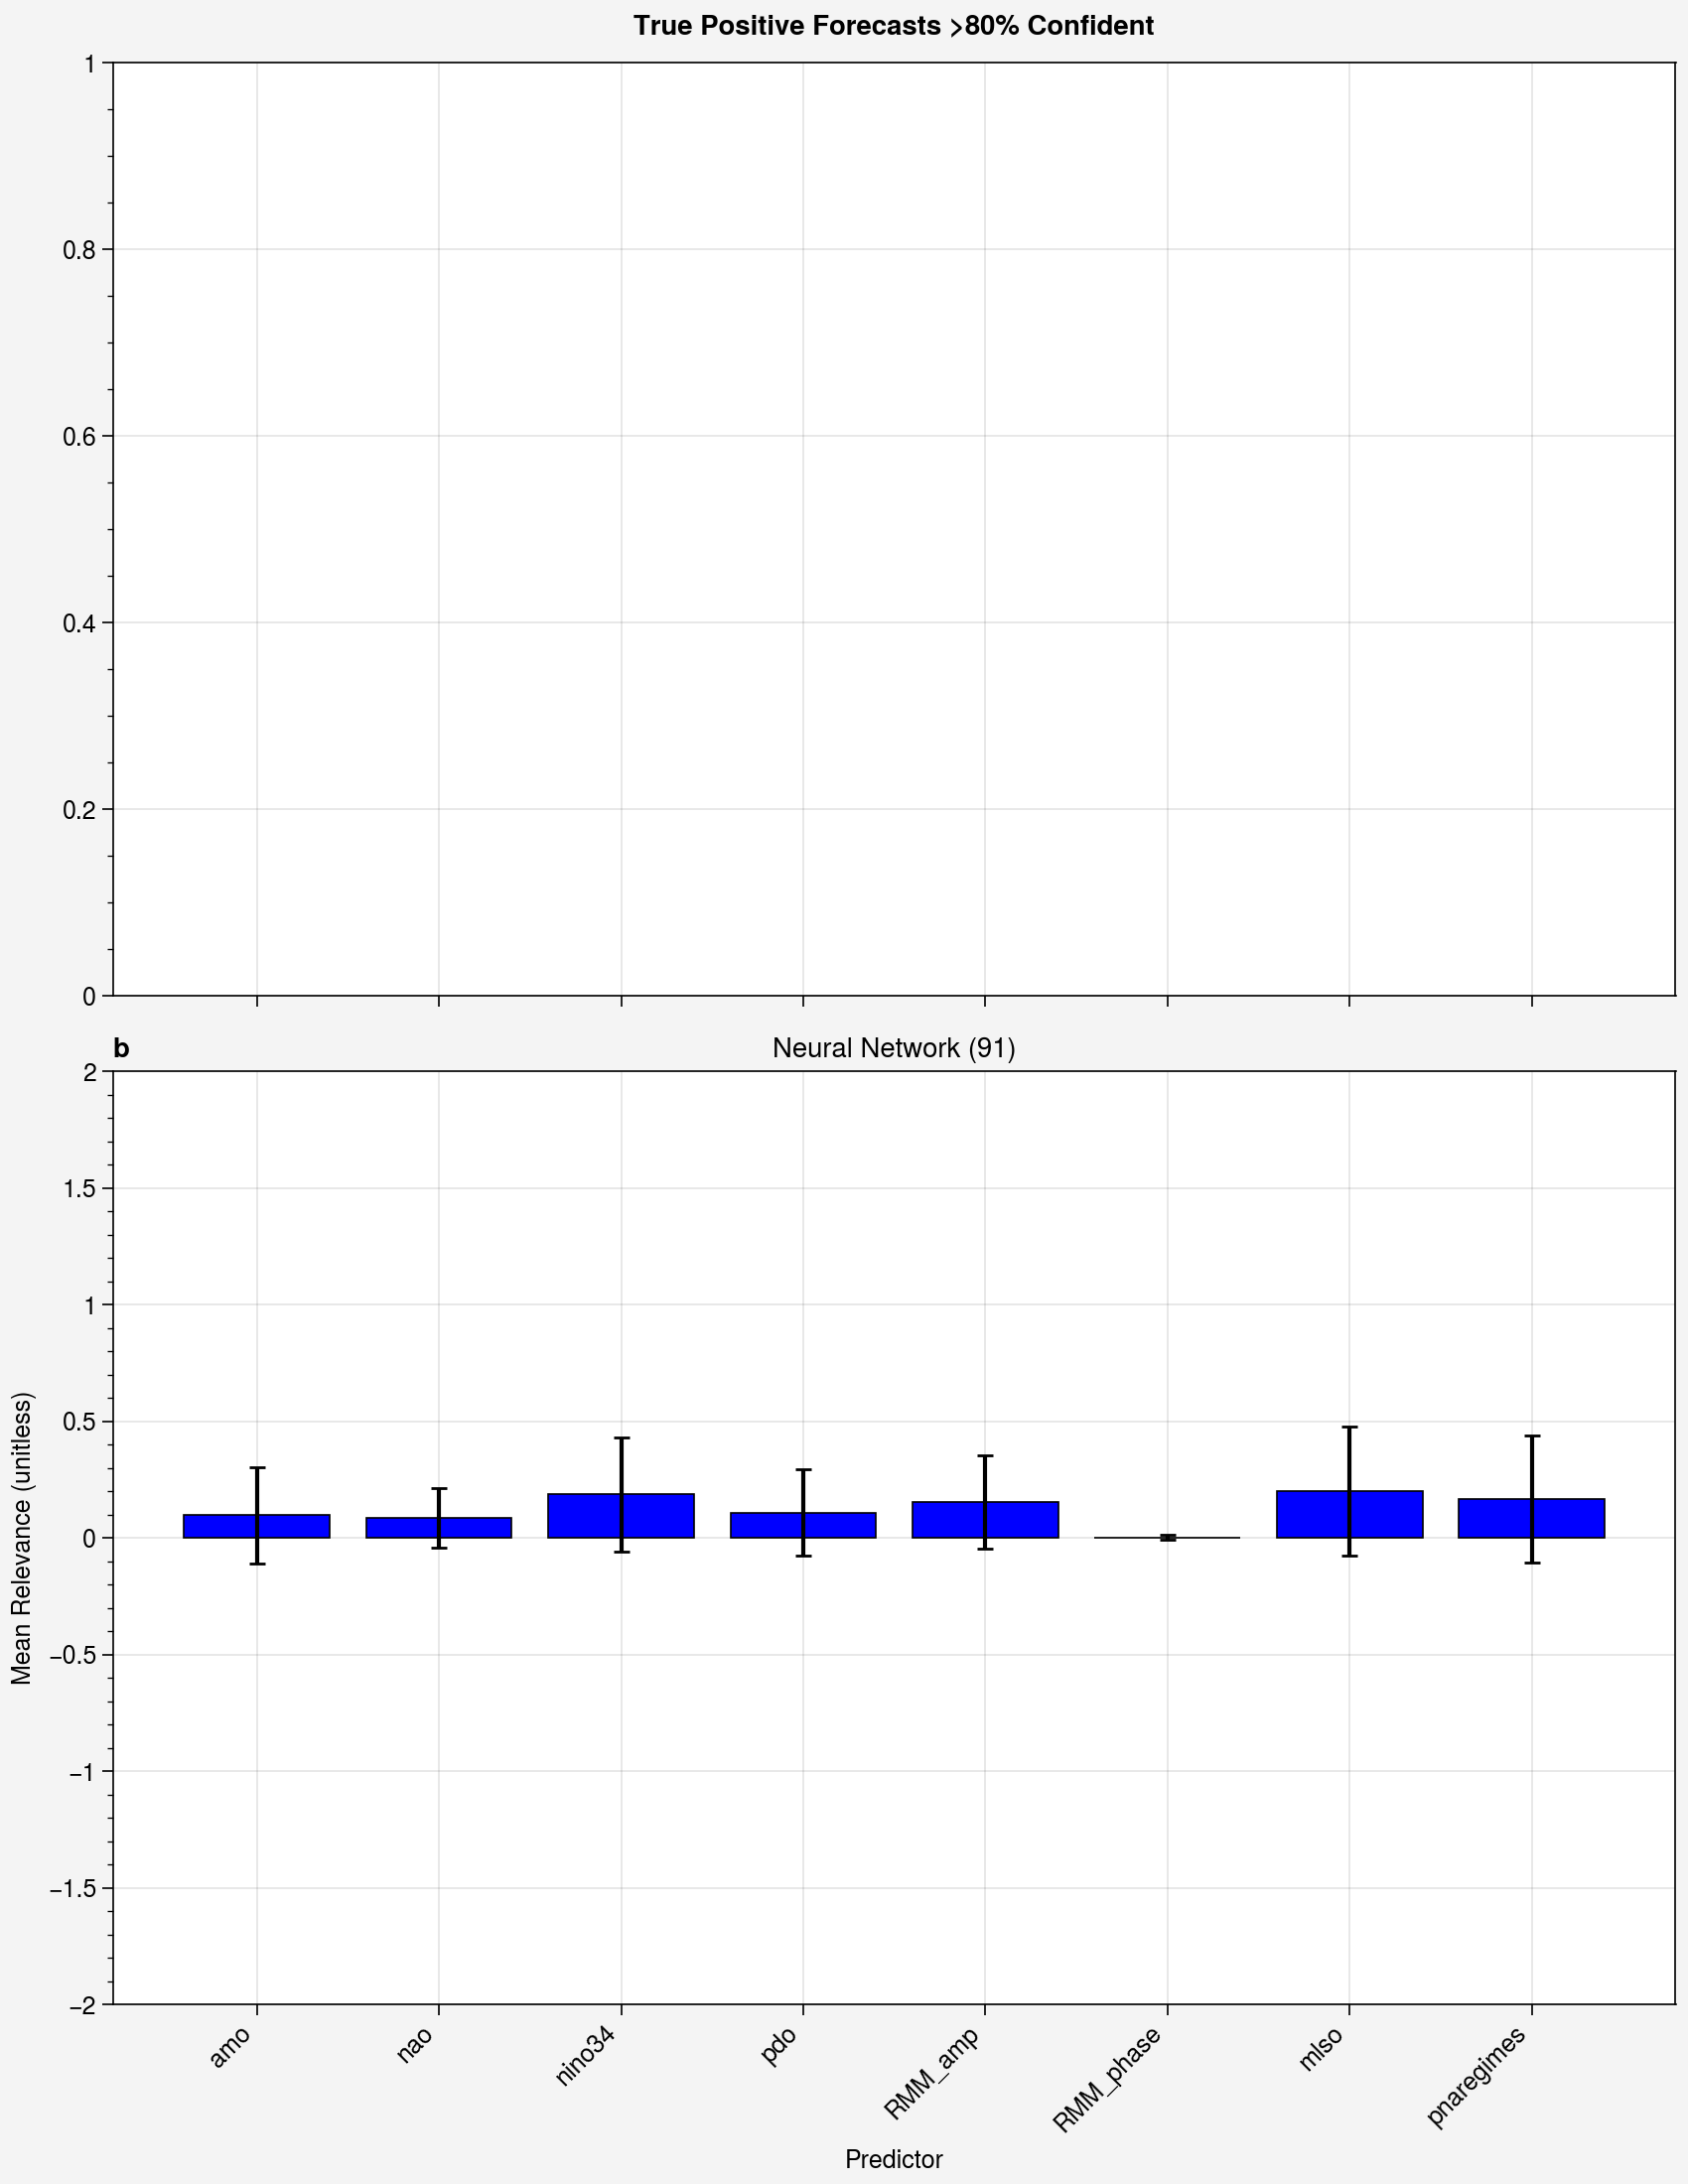

In [14]:
confidence_thresh=0.80
ds=ds_model.sel(model_type='nnmodel_med')
fcsts=ds.where(np.logical_and(ds['pred']==ds['verif'],ds['probs'].sel(cat='Upper')>=confidence_thresh))
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Upper')))))
print(count_str)
title=mtype + ': True Positive '+cat+' ('+count_str+')'

x=ds['lrp'].sel(model=0,rules=r)['features'].values
y1=fcsts['lrp'].sel(rules=r).mean(dim=['model','time'],skipna=True)
y2=fcsts['lrp'].sel(rules=r).std(dim=['model','time'],skipna=True)

f,axs=pplt.subplots(ncols=1,nrows=2,figsize=(8.5,11))

# Neural Nework Relevance
ds=ds_model.sel(model_type='nnmodel_med')
axs[1].bar(x,y1,yerr=y2,edgecolor='k',facecolor='b')  
axs[1].format(title='Neural Network ('+count_str+')',abc=True,xrotation=45,xlabel='Predictor', ylabel='Mean Relevance (unitless)',
             ylim=(-2,2))

f.format(suptitle='True Positive Forecasts >80% Confident')


### Figure 6: Mean relavance of predictors for successful forecasts with high confidence (>=80% probability) of positive precipitation anomaly

# Contribution of Predictors to Confident Unsuccessful Forecasts

19


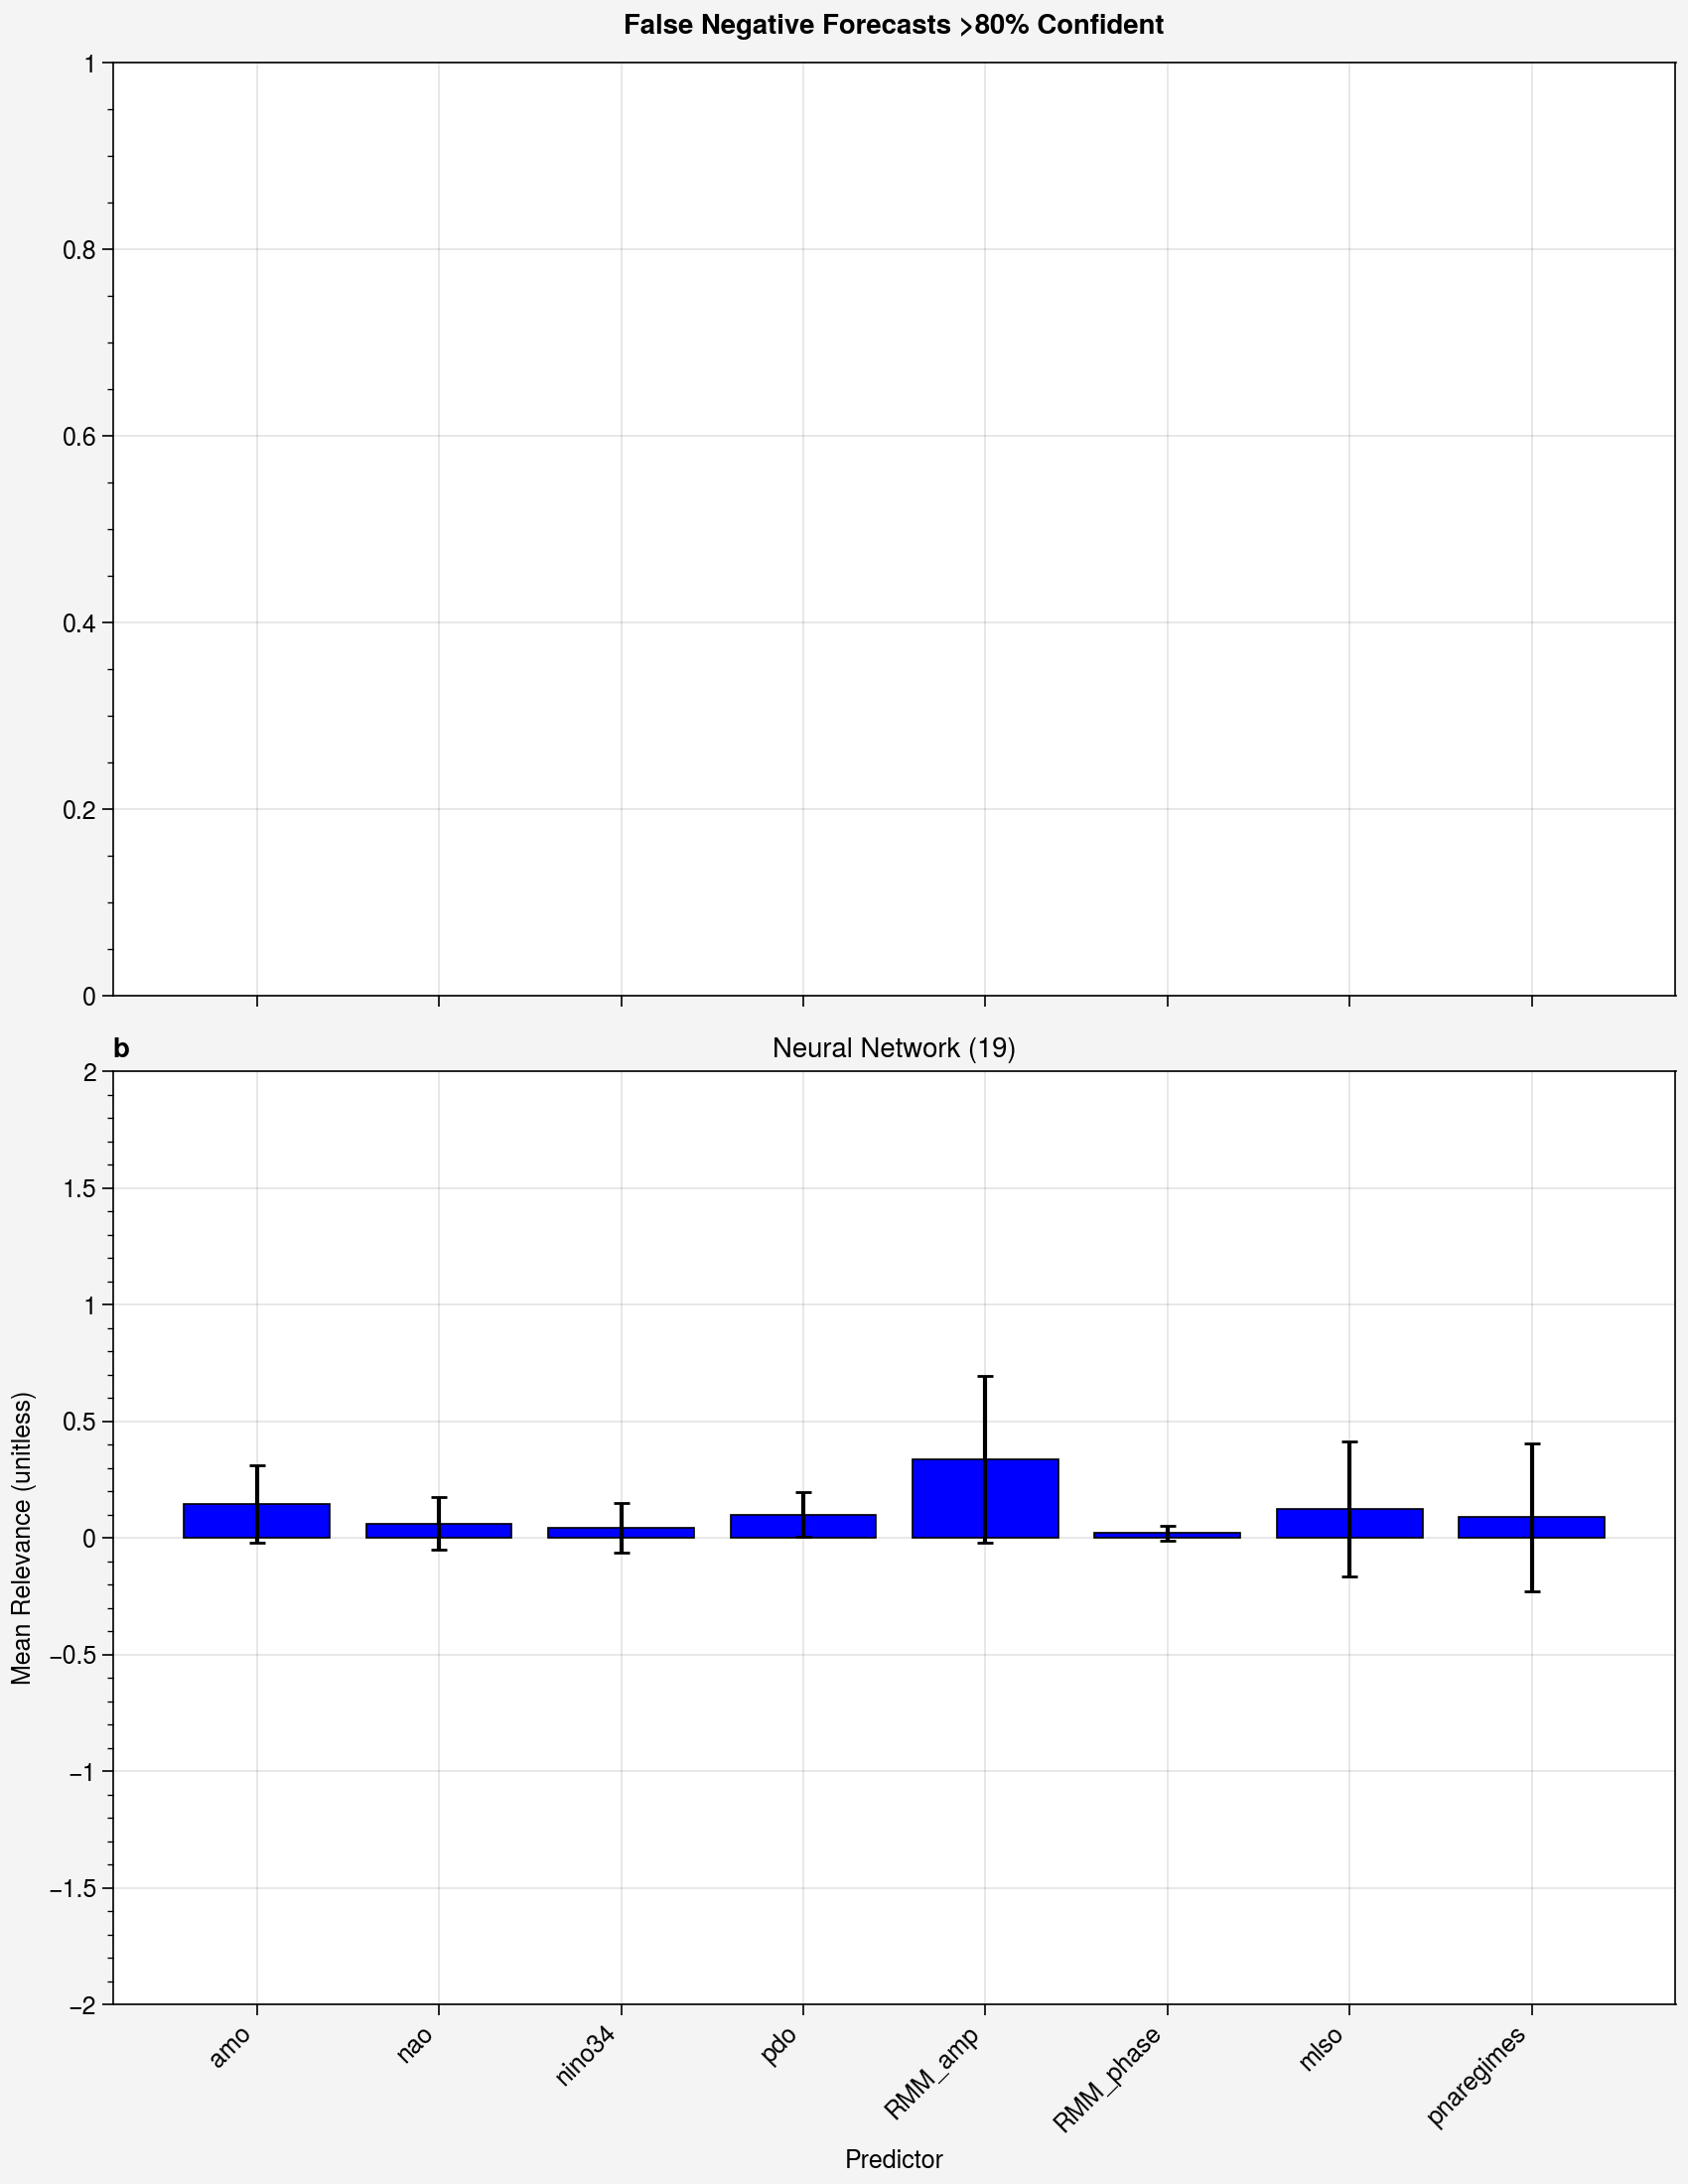

In [15]:
confidence_thresh=0.80
ds=ds_model.sel(model_type='nnmodel_med')
fcsts=ds.where(np.logical_and(ds['pred']!=ds['verif'],ds['probs'].sel(cat='Lower')>=confidence_thresh))
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Lower')))))
print(count_str)

x=ds['lrp'].sel(model=0,rules=r)['features'].values
y1=fcsts['lrp'].sel(rules=r).mean(dim=['model','time'],skipna=True)
y2=fcsts['lrp'].sel(rules=r).std(dim=['model','time'],skipna=True)

f,axs=pplt.subplots(ncols=1,nrows=2,figsize=(8.5,11))

# Neural Nework Relevance
ds=ds_model.sel(model_type='nnmodel_med')
axs[1].bar(x,y1,yerr=y2,edgecolor='k',facecolor='b')  
axs[1].format(title='Neural Network ('+count_str+')',abc=True,xrotation=45,xlabel='Predictor', ylabel='Mean Relevance (unitless)',
             ylim=(-2,2))

f.format(suptitle='False Negative Forecasts >80% Confident')


71


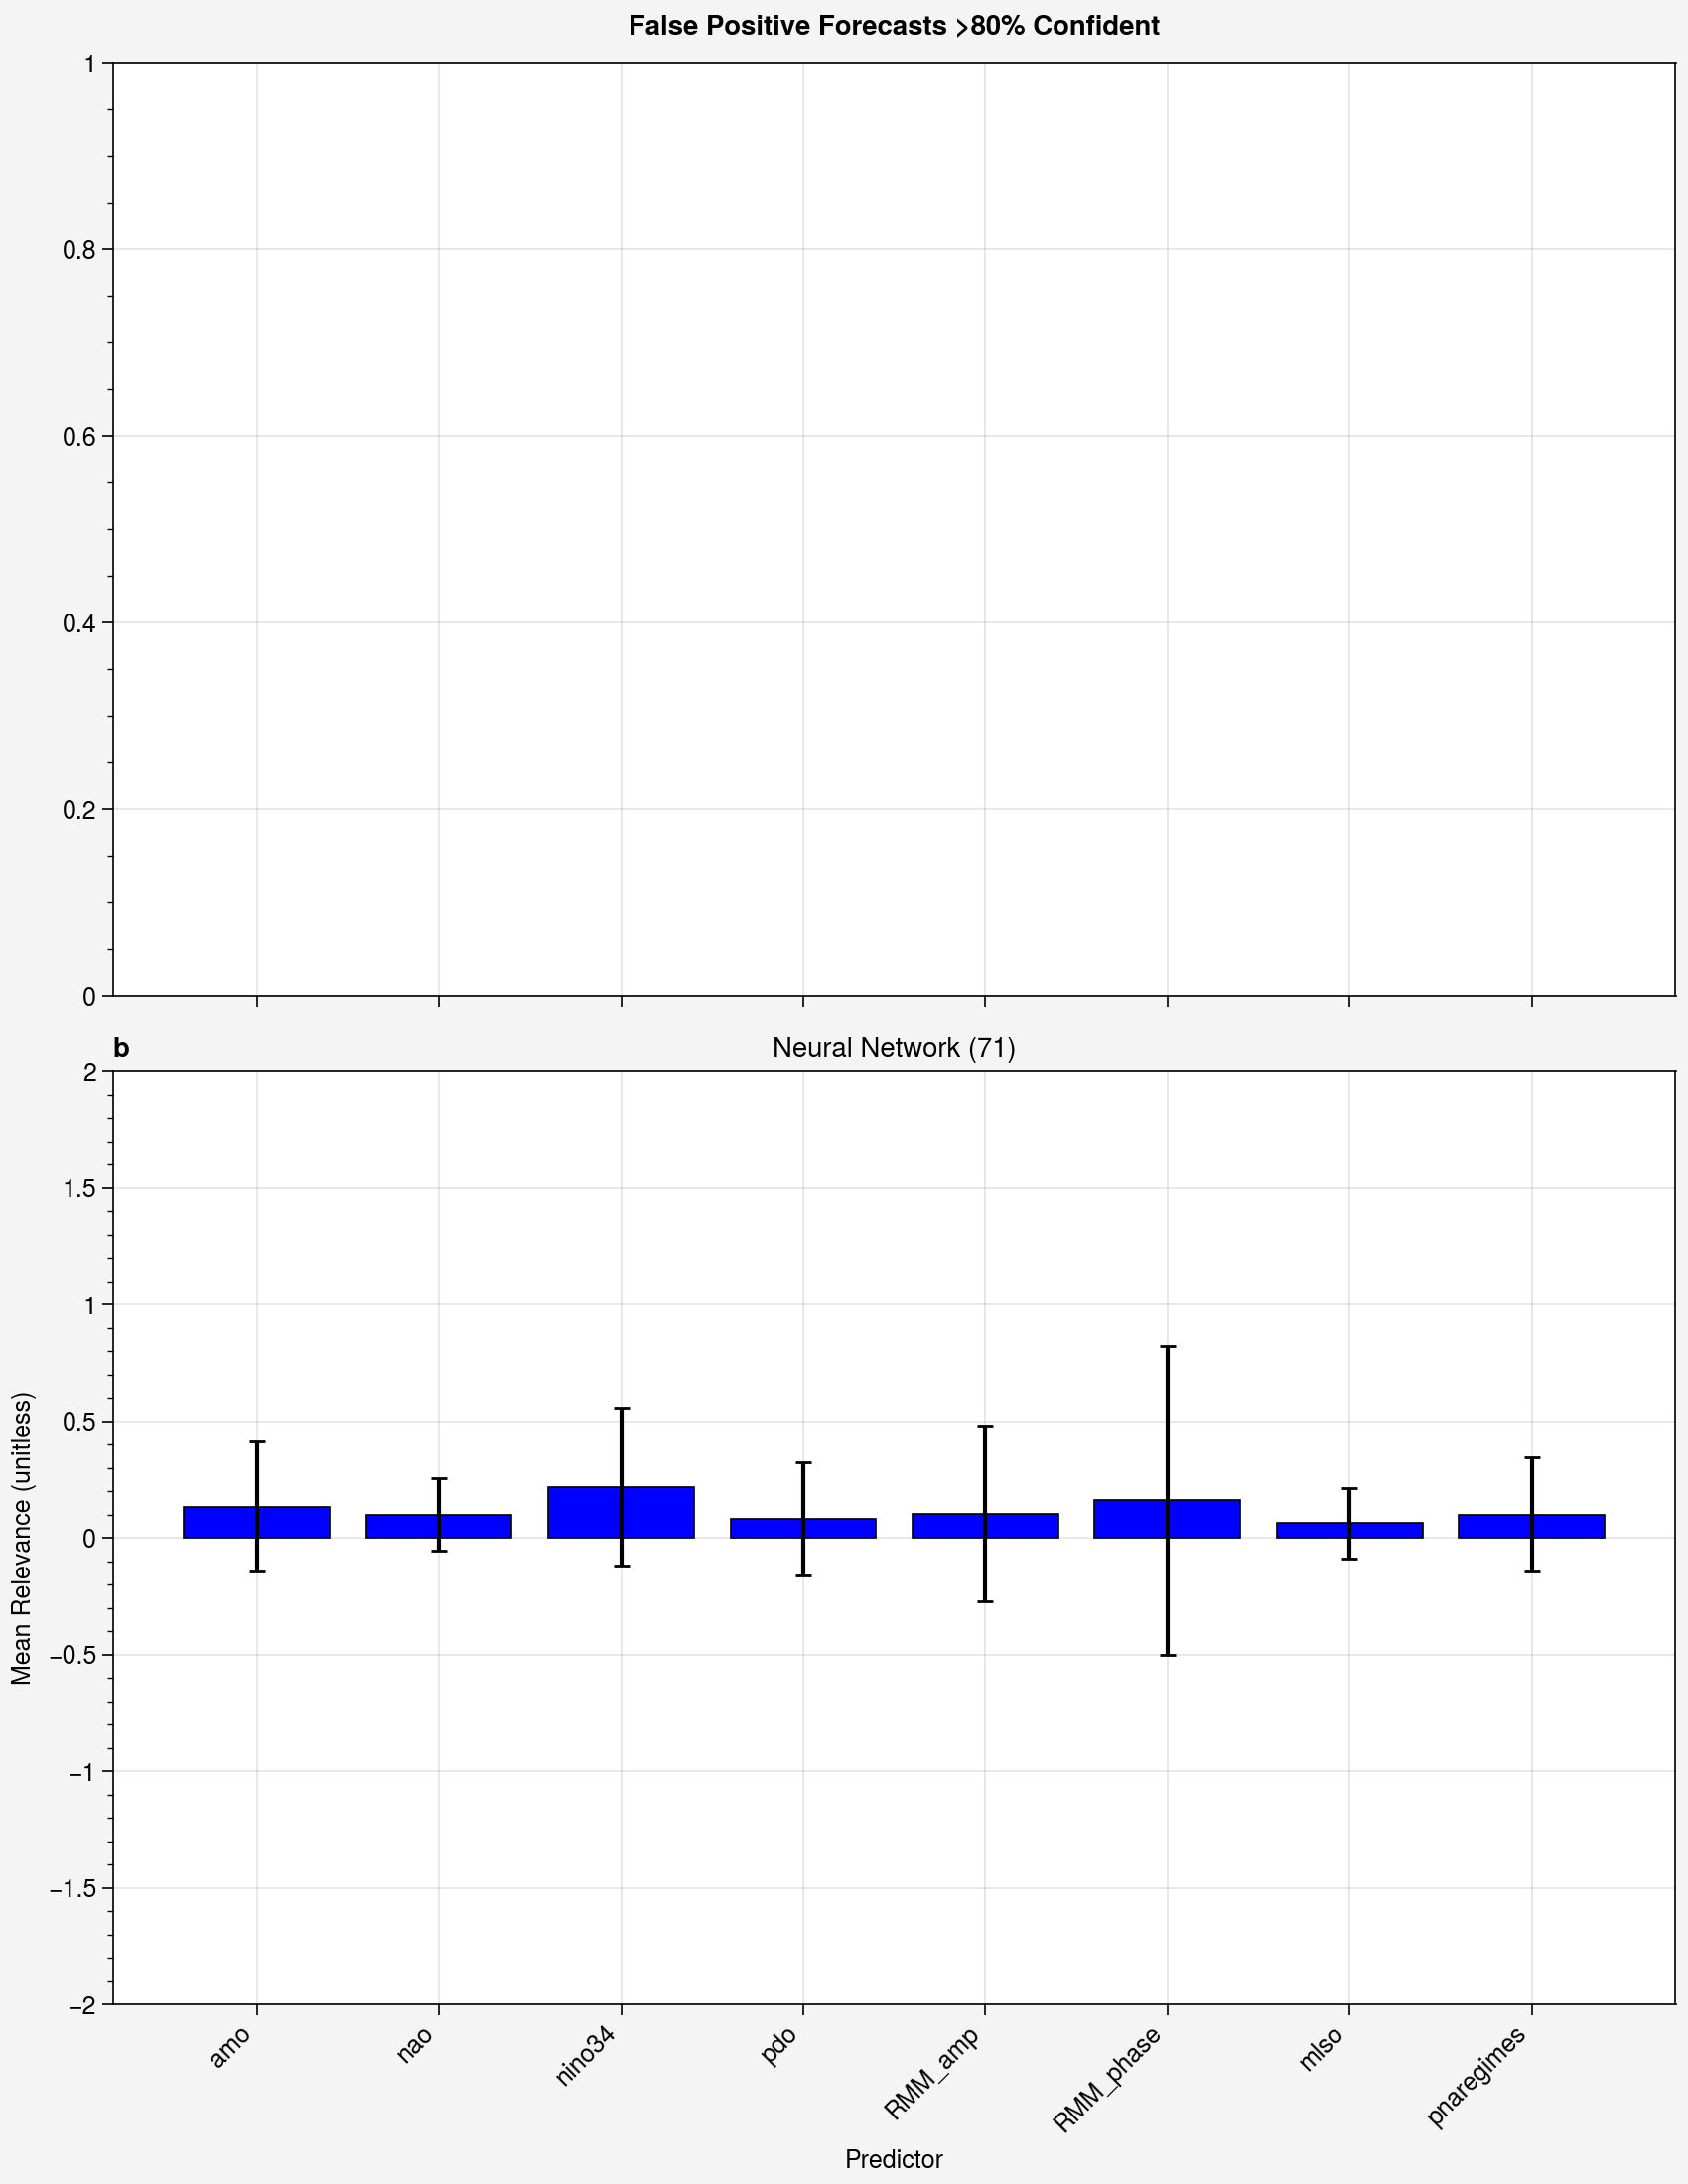

In [16]:
confidence_thresh=0.80
ds=ds_model.sel(model_type='nnmodel_med')
fcsts=ds.where(np.logical_and(ds['pred']!=ds['verif'],ds['probs'].sel(cat='Upper')>=confidence_thresh))
count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Upper')))))
print(count_str)

x=ds['lrp'].sel(model=0,rules=r)['features'].values
y1=fcsts['lrp'].sel(rules=r).mean(dim=['model','time'],skipna=True)
y2=fcsts['lrp'].sel(rules=r).std(dim=['model','time'],skipna=True)

f,axs=pplt.subplots(ncols=1,nrows=2,figsize=(8.5,11))

# Neural Nework Relevance
ds=ds_model.sel(model_type='nnmodel_med')
axs[1].bar(x,y1,yerr=y2,edgecolor='k',facecolor='b')  
axs[1].format(title='Neural Network ('+count_str+')',abc=True,xrotation=45,xlabel='Predictor', ylabel='Mean Relevance (unitless)',
             ylim=(-2,2))

f.format(suptitle='False Positive Forecasts >80% Confident')


What do I need next:
* Load model works with new environment -- rerun 100 modells
* Check time sorting for erai based datasets

Since Last Time:
 * Contingency Table confirms NN is best at predicting negative precip anomalies
 * Model is better tuned so that it is not overfit, but this does not result in reliable forecasts for training or testing
 * Proper normalization of relevance 
 * Ran the same analysis for winter, which leads to slightly different predictors, but similar conclusions.  
 * Basically it is difficult to predict even the sign of SEUS precip with this sample size and these predictors.